In [ ]:
# default_exp model.cvae
#default_cls_lvl 2

In [ ]:
#hide 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
# export
from snkrfinder.imports import *
from snkrfinder.core import *
from snkrfinder.data.munge import *
from snkrfinder.model.core import *
#from snkrfinder.model.transfer import *

from fastai.test_utils import show_install, synth_learner, nvidia_smi, nvidia_mem

In [ ]:
#hide
from nbdev.showdoc import *

# first snkrfinder.model.cvae

## OVERVIEW: cvae module - convolutional variational auto encoder

> TODO: clean up this preamble section

preamble: This is a project initiated while an Insight Data Science fellow.  It grew out of my interest in making data driven tools in the fashion/retail space I had most recently been working.   The original over-scoped idea was to make a shoe desighn tool which could quickly develop some initial sneakers based on choosing some examples, and some text descriptors.  Designs are constrained by the "latent space" defined (discovered?) by a database of shoe images.  However, given the 3 week sprint allowed for development, I pared the tool down to a simple "aesthetic" recommender for sneakers, using the same idea of utilizing an embedding space defined by the database fo shoe images.


Most of the code is derived from the work of @EtieeneT. (e.g.: TabularData https://github.com/EtienneT/TabularVAE and later https://github.com/EtienneT/vae )


### sneaker image encoding via various flavors of auto-encoder.  
- Auto Encoder: AE
    - ~~linear encoder / decoder~~
    - convolutional encoder / decoder
        - encoders
            - pretrained (e.g. resnet, mobilenet_v2)
            - 'vanilla' convolutional
            - 'vanilla' ResBlock

        - decoders
            - 'vanilla' convolutional
            - 'vanilla' ResBlock
    - Linear Latent representation (`LatentLayer`)

- Variational- Auto Encoder:  VAE or 𝜷-VAE      
    - Variational "bottleneck": "reparameterazation trick" for two variable linear latents
        - 𝜷-VAE: by increasing the relative strenght of error signal of the KLD through a beta variational parameter we can get better formed latent spaces which are somewhat "disentangled". That is have some semantic or meaningful structure in the representation. 
    - MMD- variational autoencoder uses a Linear Latent and MMD as the retularizer
        - The KLD has some problems and "over-regularizes" or simply isn't strong enough compared to the Maximum Mean Discrepancy (MMD) loss and tends to converge to a somewhat degenerate solution
        - MD regularization of the latent space has great advantage but at a computational expense



### FUTURE EXTENSIONS:
    -  model based data cleaning (widget module?)
    - GAN finetuning?
    - crappify general pattern
    - throw out based on inspection of high loss
    - try mixed labels?  things that are >50% sneakers included???
    
    
### TODO: fix loss / metrics reduction logic
batchmean should *only* apply to KLD because the mean over latents in not meaningful.
'none', 'mean', 'sum' for reduction over "batches"

all the other _scaling_ should come through alpha....


### TODO: find bugs in github actions

In [ ]:
#hide
show_install()



```text
=== Software === 
python        : 3.8.2
fastai        : 2.2.7
fastcore      : 1.3.19
fastprogress  : 0.2.7
torch         : 1.7.1
nvidia driver : 460.56
torch cuda    : 11.0 / is available
torch cudnn   : 8005 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : GeForce RTX 2070 SUPER

=== Environment === 
platform      : Linux-5.8.0-7642-generic-x86_64-with-glibc2.10
distro        : #47~1614007149~20.10~82fb226-Ubuntu SMP Tue Feb 23 02:59:01 UTC 
conda env     : fastai
python        : /home/ergonyc/anaconda3/envs/fastai/bin/python
sys.path      : /home/ergonyc/Projects/Project2.0/snkrfinder/nbs
/home/ergonyc/anaconda3/envs/fastai/lib/python38.zip
/home/ergonyc/anaconda3/envs/fastai/lib/python3.8
/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/lib-dynload

/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/site-packages
/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg
/home/ergonyc/anaconda3/envs/fastai/lib/

In [ ]:
#hide
#nvidia_smi()


In [ ]:
#hide 
# fix our base directory
print(Path().cwd())
os.chdir(L_ROOT)
print(Path().cwd())

/home/ergonyc/Projects/Project2.0/snkrfinder/nbs
/home/ergonyc/Projects/Project2.0/snkrfinder


## Using  fastai V2: data pipelining
- Datablock API


Load the saved merged database, and set the seeds.  And doublecheck our data is where we expect.

In [ ]:
#hide
df = pd.read_pickle(f"data/{COMBINED_DF}.pkl")
np.random.seed(3333)
torch.manual_seed(3333)


In [ ]:
#hide
#TODO:  fix the data layout... the links and paths are screwy
image_path = L_ROOT/"data"
#image_path = D_ROOT/DBS['zappos']
batch_size = 64

L([image_path/d for d in df.path])

(#11771) [Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8045616.9.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8045632.9.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8045650.3.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8045650.9.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8093302.3.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8093302.396.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8093302.4854.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8093302.9.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/80

In [ ]:
# export

def prep_df_for_datablocks(df):
    df = df[["path","train","test","validate","t_t_v","Category"]].copy()
    # I could remove all the "test" rows... for now i'll choose an alternate strategy:
    # Drop all the "test" rows for now, and create an "is_valid" column...
    # should probably drop a ton of columns to jus tkeep the file paths...
    # just keep what we'll need below
    df.loc[:,'is_valid'] = df.test | df.validate
    df.loc[:,'og_idx'] = df.index

    return df



In [ ]:
df = prep_df_for_datablocks(df)

In [ ]:
#export
def get_ae_btfms(stats = 'sneaker'):
    # could use globals IM_STATS['sneaker'] and IM_STATS['imagenet']
    im_stats = ([.5,.5,.5],[.5,.5,.5]) if stats == 'sneaker' else imagenet_stats
    batch_tfms = Normalize.from_stats(*im_stats)
    #batch_tfms = Normalize.from_stats([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    rand_tfms = aug_transforms(mult=1.0, 
               do_flip=True, 
               flip_vert=False, 
               max_rotate=5.0, 
               min_zoom=.95, 
               max_zoom=1.0, 
               max_lighting=0.1, 
               max_warp=0.1, 
               p_affine=0.66, 
               p_lighting=0.2, 
               xtra_tfms=None, 
               size=None, 
               mode='bilinear', 
               pad_mode='border', 
               align_corners=True, 
               batch=False, 
               min_scale=1.0)
    return rand_tfms+[batch_tfms]

def get_ae_no_aug(stats = 'sneaker'):
    im_stats = ([.5,.5,.5],[.5,.5,.5]) if stats == 'sneaker' else imagenet_stats
    batch_tfms = Normalize.from_stats(*im_stats)
    return [batch_tfms]

## FastAI "block" for autoencoder

Next we need our own version of ReadTabBatch that will return our inputs


In [ ]:
#export

# NO CLUE WHY WE NEED TO HAVE THIS.... copied
class TensorPoint(TensorBase):
    "Basic type for points in an image"
    _show_args = dict(s=10, marker='.', c='r')

    @classmethod
    def create(cls, t, img_size=None)->None:
        "Convert an array or a list of points `t` to a `Tensor`"
        return cls(tensor(t).view(-1, 2).float(), img_size=img_size)

    def show(self, ctx=None, **kwargs):
        if 'figsize' in kwargs: del kwargs['figsize']
        x = self.view(-1,2)
        ctx.scatter(x[:, 0], x[:, 1], **{**self._show_args, **kwargs})
        return ctx


class Tensor2Vect(TensorPoint): pass
# TODO:  instantiate a show method


class LatentsTensor(Tensor2Vect):
    "Basic type for latents as Tensor inheriting from TensorPoint (vectors)"
    @classmethod
    def create(cls, ts, img_size=IMG_SIZE): 
        "create IMG_SIZE attr to register plotting..."

        if isinstance(ts,tuple):
            mu,logvar = ts
        elif ts is None:
            mu,logvar = None,None
        else:
            mu = None
            logvar = None
        if mu is None: mu = torch.empty(0)
        elif not isinstance(mu, Tensor): Tensor(mu) 
        
        if logvar is None: logvar = torch.empty(0)
        elif not isinstance(logvar,Tensor): Tensor(logvar)
        
        t = torch.cat([mu,logvar],dim=-1) # in case its a batch?
                
        return cls(tensor(t).view(-1, 2).float(), img_size=img_size)
    
#     def show(self, ctx=None, **kwargs):
#         if 'figsize' in kwargs: del kwargs['figsize']
#         x = self.view(-1,2)
#         ctx.scatter(x[:, 0], x[:, 1], **{**self._show_args, **kwargs})
#         return ctx
#         mu,logvar = self
#         if not isinstance(mu, Tensor) or not isinstance(logvar,Tensor): return ctx

#         title_str = f"mu-> {mu.mean():e}, {mu.std():e}  logvar->{logvar.mean():e}, {logvar.std():e}"
    
#         if 'figsize' in kwargs: del kwargs['figsize']
#         if 'title' in kwargs: kwargs['title']=title_str
#         if ctx is None:
#             _,axs = plt.subplots(1,2, figsize=(12,6))
#             x=torch.linspace(0,1,mu[0].shape[0])
#             axs[0].scatter(x, mu[:], **{**self._show_args, **kwargs})
#             axs[1].scatter(x, logvar[:], **{**self._show_args, **kwargs})
#             ctx = axs[1]
        
#         ctx.scatter(mu[:], logvar[:], **{**self._show_args, **kwargs})
#         return ctx


In [ ]:
#export

def df_get_x(r): 
    "datablock df helper for VAE Block using `LatentTuple`"
    return image_path/r['path']

def df_get_y(r): 
    "datablock df helper for VAE Block using `LatentTuple`"
    return (df_get_x(r),None,None)

In [ ]:
#export 


def LatentsTensorBlock(): 
    "Class wrapper for the AE `LatentTensor` Block"
    return TransformBlock(type_tfms=LatentsTensor.create, batch_tfms=noop)


def df_ae_x(r,im_path=L_ROOT/"data"): 
    "Autoencoder LatentsTensorBlock datablock df helper"
    return im_path/r['path']


# need to make sure that we get the image whihc is "Identical" to the input.. how to test?

def df_ae_y(r): 
    "The target is the same as the input for AE"# lambda o: o
    return df_ae_x(r)



#export 
# could we do a typedispatch to manage the transforms...?
# def VAETargetTupleBlock(): 
#     return TransformBlock(type_tfms=VAETargetTuple.create, batch_tfms=IntToFloatTensor)

def LatentTupleBlock(): 
    "Class wrapper for the AE `LatentTuple` Block (depricated)"
    return TransformBlock(type_tfms=LatentTuple.create, batch_tfms=noop)



NameError: name 'L_ROOT' is not defined

Don't forget to set  `n_inp=1`. Otherwise the default to make the  input to 1-len(blocks).  Also note that the `FeatsResize` is used to avoid the random jittering from resize during training.  Only the very narrow batch augmentations will be used.

In [ ]:
#export
# 

def get_ae_DataBlock(aug=True,im_path=L_ROOT/"data",stats = 'sneaker',im_size=IMG_SIZE):
    "wrapper to get the standard AE datablock with `ImageBlock`,`LatentTensor` target"
    # use partials or a class wrapper to get around this yucky hack
    global image_path
    image_path = im_path
    
    mytfms = get_ae_btfms(stats=stats) if aug else get_ae_no_aug(stats=stats)
    block = DataBlock(blocks=(ImageBlock(cls=PILImage), ImageBlock(cls=PILImage), LatentsTensorBlock ),
              get_x=df_ae_x, 
              get_y=[df_ae_y, noop], #don't need to get the LatentsTensorBlock, just create
              splitter=ColSplitter('is_valid'), 
              item_tfms= FeatsResize(im_size,method='pad', pad_mode='border'),
              batch_tfms = mytfms,
              n_inp = 1)
 
    return block



In [ ]:
# hide

# block = get_ae_DataBlock(aug=True)
# block.summary(df)


In [ ]:
# hide
# dls = block.dataloaders(df, batch_size=batch_size)

In [ ]:
#hide
# dls.show_batch()

## creating the VAE

Variational Auto-Encoder for fastai

I'm going to use a generic convolutional net as the basis of the encoder, and its reverse as the decoder. This is a proof of concept for using the _fastai_ framework, and will experiment with pre-trained resnet and MobileNet_v2 later. I'd like to use the MobileNet_v2 as a direct link ot the "SneakerFinder" tool which motivated this experiment. [see SneakerFinder]

A variational "module" will sit between the encoder and decoder as the "Bottleneck". The Bottleneck will map the resnet features into a latent space (e.g. ~100 dimensions) represented of standard normal variables.  The "reparameterization trick" will sample from this space and the "decoder" will generate images. 

Finally a simple "decoder" will sample from the variational latents space and be trained to reconstruct the images. 

The intention is the latent space can be used to generate novel sneaker images.



### AE:  deterministic AutoEncoder ( _non- variational_)

Although we give up the original utility we are going for --  creating new sneakers via the latent space -- having otherwise equivalent non-variational autoencoders for reference will be great. Furthermore, this latent space representation will be amenable to a MMD regularization later on.  This will be useful to avoid some of the limitiations of the KLD as a regularizer (overestimation of variance, and some degenerate convergences).
Its sort of _hack_-ey but keeping the tooling equivalent to the betaVAE will ultimatel give some advantages.

In [ ]:
#export
class UpsampleBlock(Module):
    def __init__(self, up_in_c:int, final_div:bool=True, blur:bool=False, **kwargs):
        """
        Upsampling using PixelShuffle_INCR and ConvLayer
            - up_in_c :  "Upsample input channel"
        """
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
        ni = up_in_c//2
        nf = ni if final_div else ni//2
        self.conv1 = ConvLayer(ni, nf, **kwargs) # since we'll apply it by hand...
        self.conv2 = ConvLayer(nf, nf, **kwargs)

    def forward(self, up_in:Tensor) -> Tensor:
        up_out = self.shuf(up_in)
        return self.conv2(self.conv1(up_out))
    



In [ ]:
#export

class LatentLayer(Module):
    """
    This layer encodes the latent "bottleneck" and is constructed to work with the specified VAE DataBlock be a replacement for 
    the variational (reparameter trick) layer for otherwise identical architecture
    """
    
    def __init__(self,in_features,latent_features):
        """ 
        Compose a linear latent layer such that the mechanics are equivalent to the VAE
              the "dummy" can be used for a shaddow logvar track a KLD estimate divergence 
              from latent gaussian prior
              compute the variance across batchs for each latent feature as the dummy_var
        """       
        self.latent = nn.Linear(in_features,latent_features)
    
    def forward(self,h):
        z = self.latent(h)
        #dummy_var = (z.var(dim=1).unsqueeze(-1).expand(z.size()) ) #variance across latent dim for each image
        dummy_var = (z.var(dim=0).unsqueeze(0).expand(z.size()) ) #latent variance across batch
        dummy_mu = z
        return z, dummy_mu, dummy_var.log()
        
        #return z, torch.zeros_like(z)
    

In [ ]:
#export

class AEEncoder(Module):
    def __init__(self,arch_body,enc_dim, hidden_dim=None, im_size=IMG_SIZE):
        """
        arch_body   list of layers (e.g. arch.children()[:cut])    
        enc_dim,
        hidden_dim. number of linear features to sandwich between the feature encoder and the latent layers
        """                
        arch = arch_body + [Flatten()]

        if hidden_dim:  # i.e. is not None
            arch += [nn.Linear(enc_dim,hidden_dim)]
                    # [LinBnDrop(enc_dim,hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)]

        self.encoder = nn.Sequential(*arch)
        store_attr('enc_dim,hidden_dim')
        
    def forward(self, x):
        return self.encoder(x)



      
#### TODO: refactor this to take a "BLOCK" input so we can have either UpsampleBlocks or ResBlockUpsampleBlocks      
class AEDecoder(Module):
    def __init__(self, hidden_dim=None, latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE):
        """
        Decoder Module made of `UpsampleBlock`s returning the latent representation back into an "image"
            latent_dim - dimension of latent representation
            hidden_dim - optional additional linear layer between the latent and decoder
            im_size - passed to make sure we are scaling back to the right size
            out_range - ensures the output is on teh same scale as the _normalized_ input image
        """
        #decoder        
        n_blocks = 5              
        BASE = im_size//2**5   
        
        hidden = im_size*BASE*BASE if hidden_dim is None else hidden_dim
        z_fc = [nn.Linear(latent_dim,hidden)] # [LinBnDrop(latent_dim,hidden,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)]
        if hidden_dim:  # i.e. is not None
            z_fc += [nn.Linear(hidden,im_size*BASE*BASE)]  # should the hidden layer have activationa and/or batchnorm?
            #z_fc += [LinBnDrop(hidden,im_size*n_blocks*n_blocks,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)]
        
        
        nfs = [3] + [2**i*BASE for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleBlock(nfs[i]) for i in range(n - 2)]        
        self.decoder = nn.Sequential(*z_fc,
                                      ResizeBatch(im_size,BASE,BASE),
                                      *modules,
                                      ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
        
        store_attr('latent_dim, hidden_dim,im_size,out_range')

    def forward(self, z):    
        return self.decoder(z)
        
        

It is convenient to avoid the class wrappers to simplify the param splitting for freezing the pre-trained arcitecture.  
We could enumerate the class layers and return sequential, but simply making some functions to put the layers togeter is better.

In [ ]:
# export
    
def build_AE_encoder(arch_body,enc_dim, hidden_dim=None, im_size=IMG_SIZE):
    "wrapper to sequential-ize AEEncoder class"
    encoder = AEEncoder(arch_body,enc_dim=enc_dim, hidden_dim=hidden_dim, im_size=im_size)
    return nn.Sequential(*list(encoder.children()))

    
        
def build_AE_decoder(hidden_dim=None, latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE):
    "wrapper to sequential-ize AEDecoder class"
    decoder = AEDecoder(hidden_dim=hidden_dim, latent_dim=latent_dim, im_size=im_size,out_range=out_range)
    return nn.Sequential(*list(decoder.children()))
    

    

In [ ]:
#export
        
class AE(Module):
    def __init__(self,enc_parts,hidden_dim=None, latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE):
       
        """
        inputs:  
            arch, cut,pretrained
            enc_dim
            latent_dim
            hidden_dim
            
        """
        enc_arch,enc_feats,name = enc_parts
        
        BASE = im_size//2**5
        enc_dim = enc_feats * BASE**2  # 2**(3*3) * (im_size//32)**2 #(output of resneet) #12800

        #encoder
        self.encoder = build_AE_encoder(enc_arch,enc_dim=enc_dim, hidden_dim=hidden_dim, im_size=im_size)

        in_dim = enc_dim if hidden_dim is None else hidden_dim
        
        # AE Bottleneck
        self.bn = LatentLayer(in_dim,latent_dim)     
        
        #decoder
        self.decoder = build_AE_decoder(hidden_dim=hidden_dim, latent_dim=latent_dim, im_size=im_size,out_range=out_range)

        store_attr('name,enc_dim, in_dim,hidden_dim,latent_dim,im_size,out_range') # do i need all these?
            
    
    def decode(self, z):    
        return self.decoder(z)
    
    def encode(self, x):
        h = self.encoder(x)
        return self.bn(h)
            
    
    def forward(self, x):
        #z, mu, logvar = self.encode(x)
        #         h = self.encoder(x)
        #         z, mu, logvar = self.bn(h) # reparam happens in the VAE layer
        #         x_hat = self.decoder(z)
        
        z,mu,logvar = self.encode(x)  # z and mu are the same for 
        x_hat = self.decode(z)
        latents = torch.stack([mu,logvar],dim=-1)
        
        return x_hat, latents # assume dims are [batch,latent_dim,concat_dim]

    

#### Loss

These inherit from `Module`. (fastai's wrapper on `nn.Module`).  The base class `AELoss` initializes wiht a `batchmean`, `alpha`, and `useL1` parameters to set how the loss will be aggregated and regularized.  For the basice AutoEncoder we'll regularize the latent with a L1 to keep the magnitudes from exploding.   

> NOTE: Here `batchmean` means we will divide the loss (either L1 or L2 depending on `useL1` flag) by which uses `reduction='sum'` by the batch size.   This technically makes it a _cost_ computed for each batch.   This same convention will be used later for KL-Divergence and MMD latent regularizers.

In [ ]:
# export

        
# class L1LatentReg(Module):
#     """
#      add alpha?
#     """
#     def __init__(self, batchmean=False):
#         """
#         reduction 'sum', else 'batchmean'
        
#         """
#         l_one = self._L1mean if batchmean else self._L1
#         store_attr('batchmean,l_one')
    
#     def _L1(self, a):
#         return a.abs().sum()
    
#     def _L1mean(self, a):
#         return a.abs().sum(dim=1).mean()

#     def forward(self,z):
#         return self.l_one(z)        
            
     
class AELoss(Module):
    """
    wrapper for loss_func which deals with potential annealed kl_weight
    does MSE with 'mean' reduction
    'batchmean'  averages as 'sum' MSE over batches
    simple L1 regularizer on latent dimension
    """
    def __init__(self, batchmean=False, alpha=1.0,useL1=False):
        """
        reduction 'sum'
        
        """
        pix_loss = MSELossFlat(reduction='sum') if not useL1 else L1LossFlat(reduction='sum')
        store_attr('pix_loss,alpha,batchmean')
        
    def l_one_reg(self,pix_dim,z):
        l_one = z.abs().sum()
        l_one *= (3*pix_dim*pix_dim)/z.size()[1] 
        return l_one
    
    def forward(self, preds, *target):
        """
        pred =(x_hat,KLD,kl_weight) #mu,log_var, kl_weight)
        target is x (original) 
        """        
        # this handles the annealed kl_weight and passing the mu,logvar around we added...
        if(len(preds) == 3):
            x_hat, latents, _ = preds
        else: #if len(preds) == 2:  # we should never get here... unless we delete teh callback
            x_hat, latents = preds
            

        z, _ = latents.split(1,dim=2)
        bs = latents.size()[0]

        #note: both mse and l1_reg are summing errors over batches, and pixels or latents 
        pix_err = self.pix_loss(x_hat, target[0]) 
        pix_dim = x_hat.size()[-1]
        l1_reg = self.l_one_reg(pix_dim,z)
        
        total =  pix_err + self.alpha*l1_reg
        
        total *= (1./bs) if self.batchmean else 1.0
        
        return total

#### Metrics

These are called by the recorder callback and collect quantities to track training.  I made a simple meta class so I don't have to repreat the reset and mean value property for all the metrics.

In [ ]:
# export

class MyMetric(Metric):
    "meta-class for simple average over epoch metric quantities"
    def reset(self):
        "Clear all targs and preds"
        self.vals = []
    @property
    def value(self):
        return np.array(self.vals).mean()
    
class L1LatentReg(MyMetric):
    "Latent Regularizer with sum reduction and optinal batchmean scaling"
    def __init__(self,batchmean=False,alpha=1.0): 
        vals = []
        store_attr('vals,batchmean,alpha')
    
    def accumulate(self, learn):
        #         pix_dim = to_detach(learn.y[0].size()[-1])
        latents = to_detach(learn.pred[1])
        bs = latents.size()[0]
        z, _ = latents.split(1,dim=2)
        #nll = torch.abs(recon_x - x).mean()
        l_one = z.abs().sum()
        #         l_one *= (3*pix_dim*pix_dim)/z.size()[1] 
        l_one *= (self.alpha/bs) if self.batchmean else self.alpha

        self.vals.append(l_one)
                        
        

These are some helpers for computing the KL Divergence as a function and a `Module`

In [ ]:
# export

def KLD(mu,logvar):
    "KLD helper which sum across latents, but not batches"
    return -0.5 * torch.sum(1 + logvar - mu*mu - logvar.exp(),1)

        
class KLDiv(Module):
    """
    Module for computing the KL Divergence from a unit normal distribution.
    'batchmean' option sums first and averages over batches 
    """
    def __init__(self, batchmean=False):
        """
        reduction 'sum', else 'batchmean'
        
        """
        store_attr('batchmean')
        
    def __KLD(self,mu,logvar):
        "KLD helper which sum across latents, but not batches"
        return -0.5 * torch.sum(1 + logvar - mu*mu - logvar.exp(),1)


    def forward(self, mu, logvar):
        """
        pred =(x_hat,KLD,kl_weight) #mu,log_var, kl_weight)
        target is x (original) 
        """        
        kld = self.__KLD(mu,logvar)
        
        kld = kld.mean() if self.batchmean else kld.sum()
        return kld
    
    
        

In [ ]:
#export
    
class L2MeanMetric(MyMetric):
    "Mean square error"
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        x = to_detach(learn.y[0])
        recon_x = to_detach(learn.pred[0])
        nll = (recon_x - x).pow(2).mean()
        #nll = torch.mean((recon_x - x)**2)
        self.vals.append(nll)

class L1MeanMetric(MyMetric):
    "Mean absolute error"
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        x = to_detach(learn.y[0])
        recon_x = to_detach(learn.pred[0])
        #nll = torch.abs(recon_x - x).mean()
        nll = (recon_x - x).abs().mean()
        self.vals.append(nll)
        
class L2Metric(MyMetric):
    "Sum square error"
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        x = to_detach(learn.y[0])
        recon_x = to_detach(learn.pred[0])
        nll = (recon_x - x).pow(2).sum()
        #nll = torch.mean((recon_x - x)**2)
        self.vals.append(nll)

class L1Metric(MyMetric):
    "Sum absolute error"
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        x = to_detach(learn.y[0])
        recon_x = to_detach(learn.pred[0])
        #nll = torch.abs(recon_x - x).mean()
        nll = (recon_x - x).abs().sum()
        self.vals.append(nll)
        
        
class L2BMeanMetric(MyMetric):
    "Summed square error average across batch "
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        x = to_detach(learn.y[0])
        recon_x = to_detach(learn.pred[0])
        nll = (recon_x - x).pow(2).sum(dim=[1,2,3]).mean()
        #nll = torch.mean((recon_x - x)**2)
        self.vals.append(nll)

class L1BMeanMetric(MyMetric):
    "Summed abs error average across batch "
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        x = to_detach(learn.y[0])
        recon_x = to_detach(learn.pred[0])
        #nll = torch.abs(recon_x - x).mean()
        nll = (recon_x - x).abs().sum(dim=[1,2,3]).mean()
        self.vals.append(nll)
        
        
class KLWeightMetric(MyMetric):
    "Injected KLD weighting"
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        #kl = learn.model.kl_weight
        kl = learn.opt.hypers[0]['kl_weight']
        self.vals.append(to_detach(kl)) 
        
        
class RawKLDMetric(MyMetric):
    "KLD Metric, `batchmean` averages across batches"
    def __init__(self,batchmean=False): 
        vals = []
        _KLD = KLDiv(batchmean=batchmean)
        store_attr('vals,batchmean,_KLD')
        
    def accumulate(self, learn):
        latents = learn.pred[1]
        mu, logvar = latents.split(1,dim=2)
        kld = self._KLD(mu,logvar)
        self.vals.append(to_detach(kld)) 
        
class WeightedKLDMetric(MyMetric):
    """weighted KLD Metric, `batchmean` averages across batches
            the "effective" KLD regularization in e.g. a 𝜷-BAE
    """
    def __init__(self,batchmean=False,alpha=1.0): 
        vals = []
        _KLD = KLDiv(batchmean=batchmean)
        store_attr('vals,batchmean,alpha,_KLD')
        
    def accumulate(self, learn):      
        latents = learn.pred[1]
        mu, logvar = latents.split(1,dim=2)
        kld = self.alpha*self._KLD(mu,logvar)
        self.vals.append(to_detach(kld)) 
        #         latents = to_detach(learn.pred[1])
        #         mu, logvar = latents.split(1,dim=2)
        #         kld = _KLD(mu,logvar).mean() if self.batchmean else _KLD(mu,logvar).sum()
        #         self.vals.append(self.alpha*kld) 
        
        
class MuMetric(MyMetric):
    "average latent value (e.g. avg(`mu`)"
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        latents = to_detach(learn.pred[1])
        mu, logvar = latents.split(1,dim=2)
        self.vals.append(mu.mean())

    
class MuSDMetric(MyMetric):
    "standard deviation of latent 𝝁 value (e.g. std(`mu`) )"
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        latents = to_detach(learn.pred[1])
        mu, logvar = latents.split(1,dim=2)
        self.vals.append(mu.std())

    
class StdMetric(MyMetric):
    "average of latent 𝝈 value (e.g. std(exp(.5*`logvar`) )"
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        latents = learn.pred[1]
        mu, logvar = latents.split(1,dim=2)
        std = torch.exp(0.5 * logvar).mean()
        self.vals.append(to_detach(std)) 
        
class StdSDMetric(MyMetric):
    "standard deviation of latent 𝝈 value (e.g. std(exp(.5*`logvar`) )"
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        latents = learn.pred[1]
        mu, logvar = latents.split(1,dim=2)
        std = torch.exp(0.5 * logvar).std()
        self.vals.append(to_detach(std)) 
        
class LogvarMetric(MyMetric):
    "average of latent log(𝝈*𝝈) value (e.g. mean(`logvar`))"
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        latents = to_detach(learn.pred[1])
        mu, logvar = latents.split(1,dim=2)
        self.vals.append(logvar.mean())
                
class LogvarSDMetric(MyMetric):
    "standard deviation of latent log(𝝈*𝝈)  value (e.g. std(`logvar`)"
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        latents = to_detach(learn.pred[1])
        mu, logvar = latents.split(1,dim=2)
        self.vals.append(logvar.std())





#### metrics helpers

In [ ]:
# export

def default_AE_metrics(alpha,batchmean,useL1):
    "long-ish default list of metrics for the AE"
    
    first = L2BMeanMetric() if batchmean else L2MeanMetric()
    second = L1BMeanMetric() if batchmean else L2MeanMetric()
    
    if useL1: first,second = second,first
        
    metrics = [first,
                L1LatentReg(batchmean=batchmean,alpha=alpha),
                MuMetric(), 
                StdMetric(),
                LogvarMetric(),
                second,
                WeightedKLDMetric(batchmean=batchmean,alpha=alpha),
                MuSDMetric(), 
                LogvarSDMetric(),              
               ]
    return metrics

def short_AE_metrics(alpha,batchmean,useL1):
    "short default list of metrics for the AE"
    
    first = L2BMeanMetric() if batchmean else L2MeanMetric()
    second = L1BMeanMetric() if batchmean else L2MeanMetric()
    
    if useL1: first,second = second,first
        
    metrics = [first,
                L1LatentReg(batchmean=batchmean,alpha=alpha),
                MuMetric(),              
               ]
    return metrics


### Callback - AnnealedLoss

The AnnealedLoss Callback basically injects a kl_weight parameter into the loss so we can start training without the full KLD regularization for the beta-VAE version.

The fastai `Learner` class does the training loop.  It took me a little digging into the code to figure out how Metrics are called since its not really stated anywhere in the documentation (_Note: create PR for fastai for extra documentation on `Metrics` logic_).  By default one of the key `Callbacks` is the `Recorder`.  It prints out the training summary at each epoch (via `ProgressCallBack`) and collects all the `Metrics`. Which by default only loss is a `train_met` and others are `valid_met`.
The `Recorder` resets (maps `reset()` to all mets) the metrics `before_train` and `before_valid`. The `Recorder` maps `accumulate()` to the metrics on `after_batch`.  Finally

AnnealedLossCallback will inject the latent mu and logvar and a kl_weight variable into our loss.  The `mu` and `logvar` will be used to compute the KLD. The kl_weight is a scheduled weighting for the KLD. You can see the schedule graph of the parameter. At the beginning it will be 0, thus the KLD part of the loss will get ignored. So during 10% of training, we will fit a normal auto-encoder. Then gradually for 30% of trainning, increase kl_weight to 1 and then remain there for the remaining training time so that the auto encoder now becomes full variational. The way this callback is done, the loss will receive this parameter, but not the model.

In [ ]:
#export
        
class AnnealedLossCallback(Callback):
    "injects `kl_weight` for access during loss function calculation"
    def after_pred(self):
        kl_weight = self.learn.pred[0].new(1)
        kl_weight[0] = self.opt.hypers[0]['kl_weight'] if 'kl_weight' in self.opt.hypers[0].keys() else 1.0
        self.learn.pred = self.learn.pred + (kl_weight,)
    def after_batch(self):
        pred, latents, _ = self.learn.pred
        self.learn.pred = (pred,latents)
        
        
def default_KL_anneal_in():
    "reasonable default for 'warming up' the KL Div"
    return combine_scheds([ .7, .3], [SchedCos(0,1), SchedNo(1,1)])

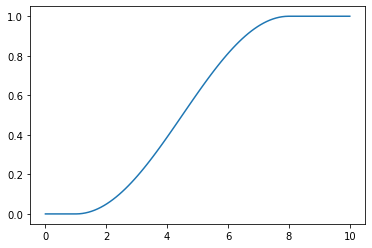

In [ ]:
# lets start with ~10 epochs of no KL regularizaiton, and ramp through the next 5
n_epochs = 10
f_init = combine_scheds([.1, .7, .2], [SchedNo(0,0),SchedCos(0,1), SchedNo(1,1)])
# f = combine_scheds([.8, .2], [SchedCos(0,0), SchedCos(0,.5)])
p = torch.linspace(0.,1.,100)
pp = torch.linspace(0.,1.*n_epochs,100)

plt.plot(pp,[f_init(o) for o in p])

> WARNING: Avoid using early stopping because the AnnealedLossCallback will make the loss grow once the KL divergence weight kicks in. 




I want to note something here that was a little confusing to me: `params(model)` is a builtin fastai `PyTorch.core` function which returns all of the parameters of the modules.    i.e.
    
```python    
def params(m):
    "Return all parameters of `m`"
    return [p for p in m.parameters()]
```


The toplevel `fastai core` functions with simple names that _almost_ match class attributes was one of my biggest stumbling blocks in getting acquainted with the fastai v2 API.  (The other is the documentation which is _autogenerated_ by the fastdev frameworks from their development noteboooks.  More on that struggle and my tips if that is troblesome for you later (here).

> NOTE: that it is crucial that you don't freeze the batch norm layers.   The `bn_splitter` collects out all the batchnorm layers.  The simple splitting we do only freezes the `encoder` and leaves the latent layers (i.e. VAE or linear encoding bottlenedck) and the `decoder` in a parameter group with the batchnorm layers.



#### parameter `Splitters`

> WARNING:  there are two completely different `splitter`s in the FastAI API.  This `splitter` groups the model parameters into groups for `freezing` and for progressive learning rates. (The other one is splits data into train and validate.  I got imminiently confused when I first started with the API by this.

> TODO:  more sophisticated parameter splitting to enable progressive learning rates

In [ ]:
#export

def bn_splitter(m):
    "splits all the batchnorm layers out"
    def _bn_splitter(l, g1, g2):
        if isinstance(l, nn.BatchNorm2d): g2 += l.parameters()
        elif hasattr(l, 'weight'): g1 += l.parameters()
        for ll in l.children(): _bn_splitter(ll, g1, g2)
        
    g1,g2 = [],[]
    _bn_splitter(m[0], g1, g2)
    
    g2 += m[1:].parameters()
    return g1,g2

def resnetVAE_split(m): 
    "simple splitter to freeze the non batch norm pre-trained encoder"
    to_freeze, dont_freeze = bn_splitter(m.encoder)
    #return L(to_freeze, dont_freeze + params(m.bn)+params(m.dec[:2]), params(m.dec[2:]))
    return L(to_freeze, dont_freeze + params(m.bn)+params(m.decoder))
    #return L(fz, nofz + params(m.bn)+params(m.dec[:6]), params(m.dec[6:]))
    

    
def AE_split(m): 
    "generic splitter for my AE classes- BVAE & AE & MMDVAE."
    to_freeze, dont_freeze = bn_splitter(m.encoder)
    return L(to_freeze, dont_freeze + params(m.bn)+params(m.decoder))
    

    


### other encoder and decoder types

> 1. MobileNet_v2 as the encoder, as a continuation of the original Sneaker Finder

> 2. simple bowtie convolutional encoder / decoder (Mimics the GOAT medium blog)
    - Architecture Hyperparameters:
        - Latent Size (research default 256, production default 32)
        - Filter Factor Size (research default 16, production default 32)
        - Latent Linear Hidden Layer Size (research default 2048, production default 1024)
        - The encoder architecture is as follows with research defaults from above:
            - Input 3x128x128 (conv2d block [conv2d, batchnorm2d, relu])
            - 16x64x64 (conv2d block [conv2d, batchnorm2d, relu])
            - 32x32x32 (conv2d block [conv2d, batchnorm2d, relu])
            - 64x16x16 (conv2d block [conv2d, batchnorm2d, relu])
            - 128x8x8 (conv2d block [conv2d, batchnorm2d, relu])
            - Flatten to 8192
            - 2048 (linear block [linear, batchnorm1d, relu])
            - Split the 2048 dimension into mu and log variance for the parameters of the latent distribution 
            - Latent mu size 256 (linear layer only with bias)
            - Latent logvar size 256 (linear layer only with bias)
        - In the middle here you can break out the BCE and KLD loss for the final loss term and use the standard reparam trick to sample from the latent distribution.
        - Decoder architecture an exact mirror 
            - Input 256
            - 2048 (linear block [linear, relu])
            - 8192 (linear block [linear, batchnorm1d, relu])
            - reshape (128x8x8)
            - 64x16x16 (conv2d transpose block [convtranspose2d, batchnorm2d, relu])
            - 32x32x32 (conv2d transpose block [convtranspose2d, batchnorm2d, relu])
            - 16x64x64 (conv2d transpose block [convtranspose2d, batchnorm2d, relu])
            - 3x128x128 (conv2d transpose [convtranspose2d, sigmoid]
        - For weight initialization I used a normal distribution centered at zero with 0.02 set for the stddev. Optimizer: Adam with default parameters, if I were to do it over again I'd spend more time here understanding the learning dynamics. The dataset was about ~10,000 with a 70/20/10 split, batch size 64, over 120 epochs, with a learning schedule to reduce when the loss started to plateau. No crazy image augmentation just resizing and standards flips. I used the ANN package Annoy to do the NN search for prod, normalizing the embeddings and using the cosine similarity, ANN factor was 128 for num_trees. 


> 3. MMD regularized VAE where the latents are drawn from a 

> TODO: Ranger optimizer might really help .. test

We can also use the transfer learning VAE tooling we previously built.  We just need to create the convolutional encoder and pass it in... Note that we don't have a pre-trained option, so DON'T FREEZE!

Now just wrap that simple conv block architecture into a _builder_.   And a meta-wrapper to let us call the conv_encoder and pre-trained options with the same function.   (I'll also put the `get_pretrained_parts` function here now even though we won't use it till the next section, so that we can make the `get_encoder_parts` generic wrapper handle both properly.)

In [ ]:
#export

#### TODO: refactor this to take a "BLOCK" input so we can have either ConvLayer or ResBlock pieces     
def get_conv_parts(im_size=IMG_SIZE):
    """
    make a simple convolutional ladder encoder
    """
    n_blocks = 5
    BASE = im_size//2**5        
    nfs = [3]+[(2**i)*BASE for i in range(n_blocks)] 
    n = len(nfs)

    modules =  [ConvLayer(nfs[i],nfs[i+1],
                            ks=5,stride=2,padding=2) for i in range(n - 1)]       

    return modules,nfs[-1],'vanilla'



def get_pretrained_parts(arch=resnet18):
    "this works for mobilnet_v2, resnet, and xresnet"
    cut = model_meta[arch]['cut']
    name = arch.__name__
    arch = arch(pretrained=True)
    enc_arch = list(arch.children())[:cut]
    enc_feats = 512
    return enc_arch, enc_feats, name



def get_encoder_parts(enc_type='vanilla',im_size=IMG_SIZE):
    encoder_parts = get_conv_parts(im_size=im_size) if isinstance(enc_type,str) else get_pretrained_parts(arch=enc_type)
    return encoder_parts # returns enc_arch,enc_dim,arch.__name__



In [ ]:
### TODO: Replace these training epochs with tests and maybe copy in some examples of the result?
##   


latent_dim = 128

# equalize KLDiv wrt errors per pixel
alpha = 3*IMG_SIZE*IMG_SIZE/latent_dim
alpha /= 20  # 5% retularizer

batchmean = True 
useL1 = False
hidden_dim = None
# SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True), 
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),  ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

metrics = default_AE_metrics(alpha,batchmean,useL1)

block = get_ae_DataBlock(aug=True)
batch_size = 64
dls = block.dataloaders(df, batch_size=batch_size)

arch='vanilla'

vae = AE(get_encoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)

# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = AELoss(batchmean=batchmean,alpha=alpha,useL1=useL1)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,


> NOTE: The `to_fp16()` callbacks work but increasing the batch size doesn't really speed things up.


In [ ]:
latent_dim = 128

# equalize KLDiv wrt errors per pixel
alpha = 3*IMG_SIZE*IMG_SIZE/latent_dim
alpha /= 20  # 5% retularizer

batchmean = True 
useL1 = False
hidden_dim = None
# SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True), 
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),  ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

metrics = default_AE_metrics(alpha,batchmean,useL1)

block = get_ae_DataBlock(aug=True)
batch_size = 64
dls = block.dataloaders(df, batch_size=batch_size)

arch='vanilla'

vae = AE(get_encoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)

# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = AELoss(batchmean=batchmean,alpha=alpha,useL1=useL1)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,
learn = learn.to_fp16()

### constructing VAE with Module Class Layers

For several of the decoder and "sampler" layers I might want to turn off the nonlinearity to give us more reasonable "gaussian" outputs to the Variational layer and the generated image which will is compared with the ImageNetStats batch-normalized image.



> IMPORTANT VAE TIP!!!   Make sure NOT to use batch normalization and non-linearity in the linear layers of the VAE.  The normalization will affect the representation and the KLD constraints.

In [ ]:
#export

class VAELinear(Module):
    "maps hidden (input) features to two latents (mu and logvar)"
    def __init__(self,in_features,latent_features):
        self.mu_linear = nn.Linear(in_features,latent_features)
        self.logvar_linear = nn.Linear(in_features,latent_features)

    def forward(self,h):
        #h = self.fc_in(h)
        return self.mu_linear(h), self.logvar_linear(h)

    
    
class VAELayer(Module):
    """
    The VAE : in_features to latent_features through 
        the "Variational" magic: "reparamaterization trick"
    """
    def __init__(self,in_features,latent_features):
        self.mu_logvar = VAELinear(in_features,latent_features)

    # 
    def reparam(self,mu,logvar):
        # should we pass through a deterministic code when not training?
        if False: return mu # self.training
    
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    
    def forward(self,h):
        mu,logvar = self.mu_logvar(h)
        #logvar = F.softplus(logvar)   # force logvar>0
        z = self.reparam(mu,logvar) # adds the noise by the reparam trick
        
        return z, mu, logvar
    
              

### simple BVAE class from VAE layer class components

This creates a pair of latents from which we can perform the "resample" trick. 

> NOTE:  this is a $\beta$-VAE (hence `BVAE` because we have a weighting factor for the KL Divergence regularazation factor which acts as a Legrangian).


Putting it all together gives us our VAE!   Note that we'll pass in the "parts" of the encoder for ease of using pretrained (or not) architectures.   The model name will correspond to the architecture of the encoder via `name`.

Note that the `BVAE` can simply inherit from the `AE` class we defined above.  Really the only difference in the `__init__` function is that a `VAELayer` which performs the reparameterization trick replaces the `AElayer` as `self.bn` 

In [ ]:
#export 
### TODO:  refactor the BVAE and AE to a single architecture... with a "sample" function ot 

class BVAE(AE):
    """
    simple VAE made with an encoder passed in, and some builder function for the Latent (VAE reparam trick) and decoder
    """
    def __init__(self,enc_parts,hidden_dim=None, latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE):
       
        """
        inputs:  
            enc_arch (pre-cut / pretrained)
            enc_dim
            latent_dim
            hidden_dim
            im_size,out_range
        """
        enc_arch,enc_feats,name = enc_parts

        # encoder
        #  arch,cut = xresnet18(pretrained=True),-4
        #  enc_arch = list(arch.children())[:cut]
        
        BASE = im_size//2**5
        enc_dim = enc_feats * BASE**2  # 2**(3*3) * (im_size//32)**2 #(output of resneet) #12800

        self.encoder = build_AE_encoder(enc_arch,enc_dim=enc_dim, hidden_dim=hidden_dim, im_size=im_size)

        in_dim = enc_dim if hidden_dim is None else hidden_dim

        # VAE Bottleneck
        self.bn = VAELayer(in_dim,latent_dim)     

        #decoder
        self.decoder = build_AE_decoder(hidden_dim=hidden_dim, latent_dim=latent_dim, im_size=im_size,out_range=out_range)

        store_attr('name,enc_dim, in_dim,hidden_dim,latent_dim,im_size,out_range') # do i need all these?


#     def decode(self, z):    
#         return self.decoder(z)

#     def encode(self, x):
#         h = self.encoder(x)
#         z, mu, logvar = self.bn(h) # reparam happens in the VAE layer
#         return z, mu, logvar

#     def forward(self, x):
#         #z, mu, logvar = self.encode(x)
#         #         h = self.encoder(x)
#         #         z, mu, logvar = self.bn(h) # reparam happens in the VAE layer
#         #         x_hat = self.decoder(z)
        
#         z,mu,logvar = self.encode(x)
#         x_hat = self.decode(z)
#         latents = torch.stack([mu,logvar],dim=-1)
        
#         return x_hat, latents # assume dims are [batch,latent_dim,concat_dim]

    
# # AE 
#    def decode(self, z):    
#         return self.decoder(z)
    
#     def encode(self, x):
#         h = self.encoder(x)
#         return self.bn(h)
            
#     def forward(self, x):
#         """
#         pass the "latents" out to keep the learn mechanics consistent... 
#         """
#         h = self.encoder(x)
#         z,logvar = self.bn(h)
#         x_hat = self.decoder(z)                    
#         latents = torch.stack([z,logvar] ,dim=-1)

#         return x_hat , latents
    


We defined a nice wrapper for building the encoder parts above.

```python
def get_pretrained_parts(arch=resnet18):
    "this works for mobilnet_v2, resnet, and xresnet"
    cut = model_meta[arch]['cut']
    name = arch.__name__
    arch = arch(pretrained=True)
    enc_arch = list(arch.children())[:cut]
    enc_feats = 512
    return enc_arch, enc_feats, name
```

Sweet, we've verified the arcitecture works, but we need to train it with a loss that constrains the variational layers with the KL Divergence.  Otherwise the simple MSE will diverge.  

### VAE Loss functions classes

This simply adds a KLD regularizer to the latent space defined by two rank-1 tensors defining gaussian-prior latents.  i.e. a mean ($\mu$) and standard deviation ($\sigma$).  

> NOTE: for convenience and numeric stability the $\sigma$ is representated as a $\log(\sigma^{s})$ so the tensors are called `mu` and `logvar`


In [ ]:
#export

# called `after_batch`

class BVAELoss(Module):
    """
    Measures how well we have created the original image, 
    plus the KL Divergence with the unit normal distribution
    batchmean option sums first and averages over batches (for smaller total error magnitudes.. cosmentic)
    """
    def __init__(self, batchmean=False, alpha=1.0,useL1=False):
        """
        reduction 'sum', else 'batchmean'
        
        """
        pix_loss = MSELossFlat(reduction='sum') if not useL1 else L1LossFlat(reduction='sum')
        _KLD = KLDiv(batchmean=False) # force to full sum
        store_attr('pix_loss,alpha,batchmean,_KLD')
        
        
    def forward(self, preds, *target):
        """
        pred =(x_hat,KLD,kl_weight) #mu,log_var, kl_weight)
        target is x (original) 
        """
        
        # this handles the annealed kl_weight and passing the mu,logvar around we added...
        if(len(preds) == 3):
            x_hat, latents, kl_weight = preds
        else: #if len(preds) == 2:  # we should never get here... unless we delete the callback
            x_hat, latents = preds
            
            kl_weight = x_hat[0].new(1)
            kl_weight[0] = 1.0
        
        mu, logvar = latents.split(1,dim=2)

        #note: both mse and KLD are summing errors over batches, and pixels or latents 
        pix_err = self.pix_loss(x_hat, target[0]) 
        kld_err = self.alpha * self._KLD(mu,logvar).sum() #_KLD doesn't sum over batches by default
        total =  (pix_err + kld_err*kl_weight) 
        if self.batchmean: total *= (1./mu.size()[0])
        return total

    


In [ ]:
# export

def default_VAE_metrics(alpha,batchmean,useL1):
    "long default list of metrics for the VAE"
    
    first = L2BMeanMetric() if batchmean else L2Metric()
    second = L1BMeanMetric() if batchmean else L1Metric()
    
    if useL1: first,second = second,first
        
    metrics = [first,
                MuMetric(), 
                StdMetric(),
                LogvarMetric(),
                WeightedKLDMetric(batchmean=batchmean,alpha=alpha),
                KLWeightMetric(), 
                second,
                MuSDMetric(), 
                StdSDMetric(), 
                LogvarSDMetric(),              
               ]
    return metrics



def short_VAE_metrics(alpha,batchmean,useL1):
    "short default list of metrics for the AE"
    
    first = L2BMeanMetric() if batchmean else L2MeanMetric()
    second = L1BMeanMetric() if batchmean else L2MeanMetric()
    
    if useL1: first,second = second,first
        
    metrics = [first,
                MuMetric(), 
                StdMetric(),
                LogvarMetric(),
                WeightedKLDMetric(batchmean=batchmean,alpha=alpha)              
               ]
    return metrics




Here's how we put everything together.  

In [ ]:
latent_dim = 128

alpha = 5
batchmean = True
useL1 = False
hidden_dim = None


cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ParamScheduler({'kl_weight':  SchedNo(1.,1.) })]

metrics = default_VAE_metrics(alpha,batchmean,useL1)



We can use this callback if we want to save the model at every epoch.  Which could be super useful if we were able to actually overfit our model. 
> 'SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True)' 




In [ ]:
#hide
block = get_ae_DataBlock(aug=True)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

enc_parts = get_pretrained_parts(arch=resnet18)

rnet_vae = BVAE(enc_parts, hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)
    
loss_func = BVAELoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, rnet_vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)

learn.freeze()

(0.0002511886414140463,
 0.0003311311302240938,
 0.00029115988581907004,
 0.00028840304003097117)

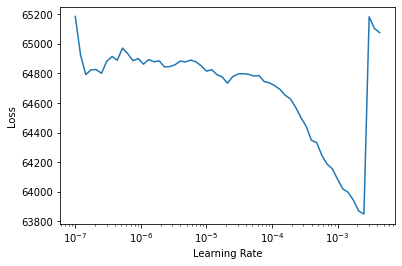

In [ ]:

# NOTE: lf_finder does NOT work correctly with our annealed kl_weight... 

lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


> NOTE: The CallBacks need to be updated for the KL loss annealing schedule as we tune.  We want to turn the `kl_weight` to 1.0 for instance when using the learning rate finder `learn.lr_find()`, and after an initial _burn in_ where the KL_loss term gradually ramps in, setting the `kl_weight` to stay at unity will be useful as we separately turn the learning rate (e.g. `fit_one_cycle` or `fit_flat_cosine`.


In [ ]:

#put in the annealied KL_weight...
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler

learn.add_cb(ParamScheduler({'kl_weight': default_KL_anneal_in()} ) )



epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,61706.023438,59401.890625,59200.527344,-0.183162,0.670351,-1.360018,1074.730103,0.182537,64435.050781,1.328313,0.744954,1.561802,00:22
1,58114.496094,54704.398438,54106.003906,-0.067606,0.709372,-1.241548,981.183960,0.604076,61621.859375,1.449838,0.450837,1.893286,00:22
2,55027.734375,52449.945312,52048.351562,-0.016363,0.778369,-0.767656,417.512909,0.947244,60466.074219,0.887459,0.376451,1.181295,00:22
3,53234.660156,51567.859375,51215.320312,-0.014475,0.771869,-0.710858,346.533447,1.000000,59968.601562,0.823350,0.310374,1.014969,00:22
4,52392.648438,51421.828125,51092.546875,-0.048797,0.782629,-0.654477,323.230713,1.000000,59896.394531,0.809924,0.289300,0.944704,00:22


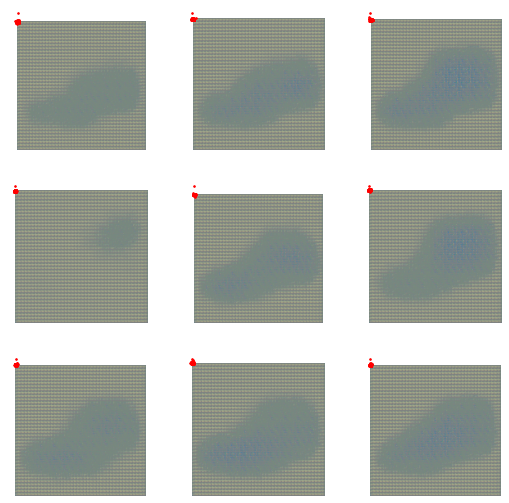

In [ ]:

n_epochs = 5

#learn.fit_one_cycle(n_epochs,lr_max= lr1)
learn.fit_one_cycle(n_epochs)
learn.show_results()


The vae with pretrained resnet encoder seems to train to a much better end-point if we keep the resnet frozen.  Hence the commented out `learn.unfreeze()` below.

In [ ]:
# replace kl_weight scheduler... with a constant unity... (NOTE: should be robust to failure if we don't replace it)
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight':  SchedNo(1.,1.) }) )

#learn.unfreeze()


In [ ]:

epochs = 20

#learn.fit_one_cycle(epochs, lr_max= 1e-3)
learn.fit_flat_cos(epochs,pct_start=.05)

epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,73116.570312,56011.906250,41707.714844,-0.162279,0.150928,-43.849857,14298.664062,1.000000,53618.125000,1.220086,0.524610,36.704914,00:22
1,55711.816406,45964.726562,33920.769531,-0.043475,0.279428,-35.963737,12039.008789,1.000000,47239.265625,1.312494,0.757988,37.766373,00:22
2,44836.546875,37305.648438,27406.685547,-0.023731,0.321513,-29.381834,9895.095703,1.000000,41459.550781,1.460417,0.538946,35.474781,00:22
3,36200.839844,30034.455078,21493.714844,-0.048967,0.376191,-24.223383,8544.314453,1.000000,35556.191406,1.591922,0.687644,33.419842,00:22
4,29243.531250,26322.974609,17289.226562,-0.076567,0.462568,-20.003771,9098.589844,1.000000,30504.798828,1.651102,1.249426,31.537554,00:23
5,23948.765625,20693.746094,14159.992188,0.015880,0.476163,-17.972431,6532.034668,1.000000,27060.267578,1.679238,0.613610,30.386091,00:22
6,18914.341797,16118.884766,10100.545898,0.071780,0.485414,-15.699727,6016.059082,1.000000,21769.064453,1.614907,0.813107,28.720329,00:22
7,16302.161133,16133.471680,9065.597656,-0.032543,0.528036,-14.508196,7064.763672,1.000000,20103.945312,1.672818,0.956630,27.728195,00:23
8,14035.663086,13486.658203,8366.876953,-0.014977,0.549360,-13.761081,5118.403809,1.000000,18096.849609,1.596557,0.572698,27.181425,00:23
9,12555.615234,12438.543945,7636.028809,-0.001427,0.551520,-12.375941,4801.065430,1.000000,16884.033203,1.493703,0.722778,25.457499,00:22


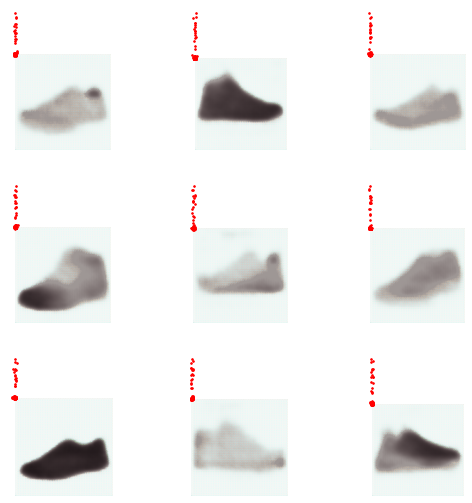

In [ ]:
learn.show_results()

### "_Vanilla_" convolutional beta-VAE

In [ ]:
latent_dim = 128

# equalize KLDiv wrt errors per pixel
#  alpha = 3*IMG_SIZE*IMG_SIZE/latent_dim
alpha = 5
batchmean = True
useL1 = False

# SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True), 
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ParamScheduler({'kl_weight': default_KL_anneal_in() })]

metrics = default_VAE_metrics(alpha,batchmean,useL1)


block = get_ae_DataBlock(aug=True)
batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='vanilla'
vae = BVAE(get_encoder_parts(arch), hidden_dim=None,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE)
                   
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = BVAELoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,






##  MMD-VAE
The MMD replace latent regularization term in loss_fn (KLD) with Maximal Meanm Discrepancy.

We'll make an MMDVAE class to keep things declarative, but its really just an AE. i.e. a linear latent layer.

Additional background on MME from [https://github.com/Saswatm123/MMD-VAE]:

> Maximum Mean Discrepancy Variational Autoencoder, a member of the InfoVAE family that maximizes Mutual Information between the Isotropic Gaussian Prior (as the latent space) and the Data Distribution.\
Short explanation: The traditional VAE is known as the ELBO-VAE, named after the Evidence Lower Bound used in its objective. The ELBO suffers from two problems: overestimation of latent variance, and uninformative latent information.\
The latter is because one of the objective's terms is the KL-Divergence between the Gaussian parameterized by the encoder and the Standard Isotropic Gaussian. This dissuades usage of the latent code, so that the KL-Divergence term is allowed to fall even further. It is important to note that the KL-Divergence should never truly reach zero, as that means the encoder is not learning useful features and cannot find feature locality, and the decoder is just randomly sampling from Standard Gaussian noise.\
The overestimation of variance results from the KL-Divergence term not being strong enough to balance against the Reconstruction Error, and thus the Encoder prefers to learn a multimodal latent distribution with spread apart means, leading to low training error as it overfits, but low quality samples as well, as the sampling distribution is assumed to be a Standard Isotropic Gaussian. One effort to mitigate this effect is the Disentangled Variational Autoencoder, which simply raises the weight on the KL-Divergence term. However, this increases the problem stated in the paragraph above since it further penalizes using the latent code.\
For more detailed explanations, I used these resources to learn, in order of usefulness to me:\
    - https://arxiv.org/pdf/1706.02262.pdf \
    - http://ruishu.io/2018/03/14/vae/ \
    - http://approximateinference.org/accepted/HoffmanJohnson2016.pdf \
    - https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/ \
    - http://bjlkeng.github.io/posts/variational-bayes-and-the-mean-field-approximation/ \
    - https://ermongroup.github.io/cs228-notes/inference/variational/ \

In [ ]:
# export

def gaussian_kernel(a, b):
    "helper for computing MMD"
    dim1_1, dim1_2 = a.shape[0], b.shape[0]
    depth = a.shape[1]
    a = a.view(dim1_1, 1, depth)
    b = b.view(1, dim1_2, depth)
    a_core = a.expand(dim1_1, dim1_2, depth)
    b_core = b.expand(dim1_1, dim1_2, depth)
    numerator = (a_core - b_core).pow(2).mean(2)/depth
    return torch.exp(-numerator)

def MMD(a, b):
    "Max Mean Discrepancy"
    return gaussian_kernel(a, a).mean() + gaussian_kernel(b, b).mean() - 2*gaussian_kernel(a, b).mean()
        
def rawMMD(a, b):
    "_raw_ values from gauss kernals, assuming that and b have the same shape"
    return gaussian_kernel(a, a) + gaussian_kernel(b, b) - 2*gaussian_kernel(a, b)



# the MMDVAE is built on the basic AE archiecure
class MMDVAE(AE): pass
    

class MaxMeanDiscrepancy(Module):
    """
     MMD
     add alpha?
    """
    def __init__(self, batchmean=False):
        """
        reduction 'mean', else 'batchmean' means only over batch
        
        """
        MMD = self._MMDsum if batchmean else self._MMDmean
        store_attr('batchmean,MMD')
    
    def _gaus_ker(self,a, b):
        "gaussian kernal"
        dim1_1, dim1_2 = a.shape[0], b.shape[0]
        depth = a.shape[1]
        numerator = 1.0/depth
        a = a.view(dim1_1, 1, depth)
        b = b.view(1, dim1_2, depth)
        a_core = a.expand(dim1_1, dim1_2, depth)
        b_core = b.expand(dim1_1, dim1_2, depth)
        a_m_b = a_core - b_core
        numerator *= (a_m_b*a_m_b).mean(2)  
        #numerator = (a_core - b_core).pow(2).mean(2)   /depth
        return torch.exp(-numerator)
    
    def _rawMMD(self, a, b):
        return self._gaus_ker(a, a) +  self._gaus_ker(b, b) - 2*self._gaus_ker(a, b)
    
    def _MMDmean(self, a, b):
        return self._rawMMD( a, b).mean()

    def _MMDsum(self, a, b):
        return self._rawMMD( a, b).sum()
    

    def forward(self,true_samples, latent):
#         bs = latents.size()[0]
#         latent_dim = z.size()[1]
#         true_samples = torch.randn((bs,latent_dim), requires_grad=False).cuda()
        mmd = self.MMD(true_samples, latent)        
        return mmd
        
        
class MMDLoss(Module):
    """
    Measures mean square error of prediction and original image, 
    regularized by MMD.
    
    Note: using reuction = 'mean' because it keeps the regularization relatively potent (i.e. pixels>>latents)
    """
    def __init__(self, batchmean=False, alpha=1.0,useL1=False):
        """
        reduction 'sum', else 'batchmean'
        
        """
        if batchmean:
            pix_loss = MSELossFlat(reduction='sum') if not useL1 else L1LossFlat(reduction='sum') 
            #mmd = _MMDsum
        else:
            pix_loss = MSELossFlat(reduction='mean') if not useL1 else L1LossFlat(reduction='mean') 
            #mmd = _MMD

        mmd = MaxMeanDiscrepancy(batchmean=batchmean)
        store_attr('pix_loss,alpha,batchmean,mmd')
        
        
    def forward(self, preds, *target):
        """
        pred =(x_hat,KLD,kl_weight) #mu,log_var, kl_weight)
        target is x (original) 
        """
        
        # this handles the annealed kl_weight and passing the mu,logvar around we added...
        if(len(preds) == 3):
            x_hat, latents, kl_weight = preds
        else: #if len(preds) == 2:  # we should never get here... unless we delete teh callback
            x_hat, latents = preds
            
            kl_weight = x_hat[0].new(1)
            kl_weight[0] = 1.0
        
        z, _ = latents.split(1,dim=2)

        #note: both mse and KLD are summing errors over batches, and pixels or latents 
        pix_err = self.pix_loss(x_hat, target[0]) 
        

        bs = latents.size()[0]
        latent_dim = z.size()[1]
        true_samples = torch.randn((bs,latent_dim), requires_grad=False).cuda()
        mmd_loss = self.mmd(true_samples, z) * self.alpha    
    
        total =  (pix_err + mmd_loss*kl_weight) 
        total *= (1./bs) if self.batchmean else 1.0
        return total

            

    
class MMDMetric(MyMetric):
    def __init__(self,batchmean=False,alpha=1.0): 
        vals = []
        #mmd = _MMDsum if batchmean else _MMD
        mmd = MaxMeanDiscrepancy(batchmean=batchmean)

        store_attr('vals,batchmean,alpha,mmd')
        
    def accumulate(self, learn):        
        latents = learn.pred[1]
        z, _ = latents.split(1,dim=2)

        bs = latents.size()[0]
        latent_dim = z.size()[1]
        true_samples = torch.randn((bs,latent_dim), requires_grad=False).cuda()
        mmd_loss = self.mmd(true_samples, z)   
        mmd_loss *= (self.alpha/bs) if self.batchmean else self.alpha

        self.vals.append(to_detach(mmd_loss))

# export

def short_MMEVAE_metrics(alpha,batchmean,useL1):
    "short list of metrics for the VAE"
    
    first = L2BMeanMetric() if batchmean else L2MeanMetric()
    second = L1BMeanMetric() if batchmean else L1MeanMetric()
    
    if useL1: first,second = second,first
        
    metrics = [first,
                MMDMetric(batchmean=batchmean,alpha=alpha), 
                MuMetric(), 
                MuSDMetric(), 
                ]
    return metrics

def default_MMEVAE_metrics(alpha,batchmean,useL1):
    "long default list of metrics for the VAE"
    
    first = L2BMeanMetric() if batchmean else L2MeanMetric()
    second = L1BMeanMetric() if batchmean else L1MeanMetric()
    
    if useL1: first,second = second,first
        
    metrics = [first,
                MMDMetric(batchmean=batchmean,alpha=alpha), 
                MuMetric(),
                StdMetric(),
                second,
                MuSDMetric(), 
                LogvarMetric(),
                L1LatentReg(batchmean=batchmean,alpha=alpha),
                WeightedKLDMetric(batchmean=batchmean,alpha=alpha),
                LogvarSDMetric()]               
    return metrics




NameError: name 'AE' is not defined

#### Vanilla MMD VAE

Simply call our `get_encoder_parts` with `arch='vanilla'` in the `MMDVAE` builder. 

In [ ]:
latent_dim = 128

cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
alpha = 20

batchmean = True
useL1 = False
hidden_dim = None
metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='vanilla'
vae = MMDVAE(get_encoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)

loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=useL1)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,
    

### ResNet Encoder MMDVAE

We build these by passing `resnet18` (_not_ `'resnet18'`) to `get_encoder_parts` helper for the parts to init the `MMDVAE`.

First a traditional "fine_tune" type of training: 

In [ ]:

latent_dim = 128

cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 10

batchmean = True
useL1 = False
hidden_dim = None
metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)


arch=resnet18
vae = MMDVAE(get_encoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)

loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=useL1)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,
    
learn.freeze()


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
learn.freeze()
n_epoch = 20
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
learn.fit_one_cycle(n_epoch)#,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 20
learn.unfreeze()
#learn.fit_flat_cos(n_epoch, lr=lr1, div_final=1e6, pct_start=0.7)
#learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e5, pct_start=0.5)
learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()


#### vanilla-resnet MMD VAE
##### no freeze

We build these by passing `resnet18` (_not_ `'resnet18'`) to `get_encoder_parts` helper for the parts to init the `MMDVAE`.

> NOTE: our architecture trains best when simply starting with the pretrained weights.  Trying to "fine_tune" by training the backend on a _frozen_ resnet and then unfreezing doesn't work with the parameter groupings from the `AE_split`.  The `learn.unfreeze()` doesn't actually do anythign (_unfrozen_ is default) but makes is clear we are _un_ -frozen

In [ ]:

latent_dim = 128

cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]


alpha = 10

batchmean = True
useL1 = False
hidden_dim = None
metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)


arch=resnet18
vae = MMDVAE(get_encoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim, im_size=IMG_SIZE,out_range=OUT_RANGE)

loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=useL1)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,
    
    
    
learn.unfreeze()


## vanilla-resnet MMD-VAE
##### ResBlocks replacing Conv2d in encoder AND decoder.
'Vanilla' encoder architecture made with `ResBlock` layers instead of `ConvLayer` layers and `Mish` activation.

In [ ]:
# hide
## This block is for experimenting with making a builder which can take ResBlock or ConvLayers (ConvBlocks?  ConvLayer(ni,nf),ConvLayer(nf,nf)??

def get_conv_parts2(enc_type='vanilla',im_size=IMG_SIZE):
    """
    make a simple convolutional ladder encoder
    TODO:  make a switch on enc_type
        - vanilla, resnet or vanilla-res
        -TODO: change to 'convblock' and 'resblock'
    """
    n_blocks = 5
    BASE = im_size//2**5        
    nfs = [3]+[(2**i)*BASE for i in range(n_blocks)] 
    n = len(nfs)

    
    
    modules =  [ConvLayer(nfs[i],nfs[i+1],
                            ks=5,stride=2,padding=2) for i in range(n - 1)]       
    
#     modules =  [ResBlock(1, nfs[i],nfs[i+1], 
#                          stride=2, act_cls=Mish)  for i in range(n - 1)]       

    return modules,nfs[-1],'vanilla'


def get_encoder_parts2(enc_type='vanilla',im_size=IMG_SIZE):
    encoder_parts = get_conv_parts2(enc_type=enc_type,im_size=im_size) if isinstance(enc_type,str) else get_pretrained_parts(arch=enc_type)
    return encoder_parts # returns enc_arch,enc_dim,arch.__name__


In [ ]:
#export
class UpsampleResBlock(Module):
    def __init__(self, up_in_c:int, final_div:bool=True, blur:bool=False, **kwargs):
        """
        Upsampling using PixelShuffle_INCR and ResBlocks
        - up_in_c :  "Upsample input channel"
        """
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
        ni = up_in_c//2
        nf = ni if final_div else ni//2
        self.conv1 = ResBlock(1,ni, nf, **kwargs) # since we'll apply it by hand...
        self.conv2 = ResBlock(1,nf, nf, **kwargs)

    def forward(self, up_in:Tensor) -> Tensor:
        up_out = self.shuf(up_in)
        return self.conv2(self.conv1(up_out))
    


def get_resblockencoder_parts(enc_type='vanilla',im_size=IMG_SIZE):
    """
    make a simple (hence 'vanilla') convolutional ladder encoder with ResBlock parts
    """
    n_blocks = 5
    BASE = im_size//2**5        
    nfs = [3]+[(2**i)*BASE for i in range(n_blocks)] 
    n = len(nfs)

    
    modules =  [ResBlock(1, nfs[i],nfs[i+1], 
                          stride=2, act_cls=Mish)  for i in range(n - 1)]       

    return modules,nfs[-1],'resblock'



# def build_ResBlockAE_decoder(hidden_dim=2048, latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE):
#         BASE = im_size//2**5
#         #store_attr('enc_dim,latent_dim, hidden_dim,im_size')

        

#         #decoder
#         n_blocks = 5        
#         nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
#         nfs.reverse()
#         n = len(nfs)
        
#         modules =  [UpsampleResBlock(nfs[i]) for i in range(n - 2)]        
#         decoder = nn.Sequential( LinBnDrop(latent_dim,hidden_dim,
#                                                 bn=True,# batch normalizaiton shouldn't be a problem here
#                                                 p=0.0,act=nn.ReLU(),lin_first=True),
#                                      LinBnDrop(hidden_dim,im_size*n_blocks*n_blocks,
#                                                 bn=True,# batch normalizaiton shouldn't be a problem here
#                                                 p=0.0,act=nn.ReLU(),lin_first=True),
#                                       ResizeBatch(im_size,n_blocks,n_blocks),
#                                       *modules,
#                                       ResBlock(1,nfs[-2],nfs[-1],
#                                                 ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
#                                                 act_cls=partial(SigmoidRange, *out_range)))
        
#         return decoder


class ResBlockAEDecoder(Module):
    def __init__(self, hidden_dim=None, latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE):
        """
        Decoder Module made of ResBlocks returning the latent representation back into an "image"
            latent_dim - dimension of latent representation
            hidden_dim - optional additional linear layer between the latent and decoder
            im_size - passed to make sure we are scaling back to the right size
            out_range - ensures the output is on teh same scale as the _normalized_ input image
        """
        #decoder
        n_blocks = 5 
        BASE = im_size//2**5               
        
        hidden = im_size*BASE*BASE if hidden_dim is None else hidden_dim
        z_fc = [nn.Linear(latent_dim,hidden)]
        if hidden_dim:  # i.e. is not None
            z_fc += [nn.Linear(hidden,im_size*BASE*BASE)]
        
        nfs = [3] + [2**i*BASE for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleResBlock(nfs[i]) for i in range(n - 2)]        
        self.decoder = nn.Sequential(*z_fc,
                                      ResizeBatch(im_size,BASE,BASE),
                                      *modules,
                                      ResBlock(1,nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
        
        store_attr('latent_dim, hidden_dim,im_size,out_range')

    def forward(self, z):    
        z = self.decoder(z)
        return z
            
    
def build_ResBlockAE_decoder(hidden_dim=None, latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE):
    "wrapper to sequential-ize ResBlockAEDecoder class"
    decoder = ResBlockAEDecoder(hidden_dim=hidden_dim, latent_dim=latent_dim, im_size=im_size,out_range=out_range)
    return nn.Sequential(*list(decoder.children()))
    

    
class ResBlockAE(AE):
    def __init__(self,enc_parts,hidden_dim=None, latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE,isVAE=False):
       
        """
        inputs:  
            enc_parts - encoder architecture 
            latent_dim - dimension of latent representation
            hidden_dim - optional additional linear layer between the latent and decoder
            im_size - passed to make sure we are scaling back to the right size
            out_range - ensures the output is on teh same scale as the _normalized_ input image
            isVae - switch for the type of latent representation
            
        """
        enc_arch,enc_feats,name = enc_parts
        
        BASE = im_size//2**5
        enc_dim = enc_feats * BASE**2  # 2**(3*3) * (im_size//32)**2 #(output of resneet) #12800

        #encoder
        self.encoder = build_AE_encoder(enc_arch,enc_dim=enc_dim, hidden_dim=hidden_dim, im_size=im_size)

        in_dim = enc_dim if hidden_dim is None else hidden_dim
        
        # AE Bottleneck
        latent = VAELayer if isVAE else LatentLayer
        
        self.bn = latent(in_dim,latent_dim)     
        
        #decoder
        self.decoder = build_ResBlockAE_decoder(hidden_dim=hidden_dim, latent_dim=latent_dim, im_size=im_size,out_range=out_range)

        store_attr('name,enc_dim, in_dim,hidden_dim,latent_dim,im_size,out_range') # do i need all these?
        

    
        
#     def decode(self, z):    
#         return self.decoder(z)
    
#     def encode(self, x):
#         h = self.encoder(x)
#         return self.bn(h)
            
#     def forward(self, x):
#         """
#         pass the "latents" out to keep the learn mechanics consistent... 
#         """
#         h = self.encoder(x)
#         z,logvar = self.bn(h)
#         x_reconst = self.decoder(z)                    
#         latents = torch.stack([z,logvar] ,dim=-1)

#         return x_reconst , latents
    

Finally we can use the `ResBlockBVAE` which instantiates a `ResBlock` `decoder` to optimize the architecture.  This is following the fastAI API lessong from the "bag of tricks" ResNet paper (CITATION), which is a general true-ism which could be glibly states as: "replacing a `Conv` with a `ResBlock` always gets you better results".  The Class constructor `ResBlockAE` takes `isVAE` to switch between `AELayer` and `LatentLayer` latents.

> TODO:  update AE class to make a VAE or AE based on the `isVAE` switch

In [ ]:
latent_dim = 128
alpha = 5 # doubled because latent is half?
batchmean = True
useL1 = False

# SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True), 
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ParamScheduler({'kl_weight':  SchedNo(1.,1.) })]


metrics = default_VAE_metrics(alpha,batchmean,useL1)


block = get_ae_DataBlock(aug=True)
batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resnblock'
vae = ResBlockAE(get_resblockencoder_parts(arch), hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE,isVAE= True)
                   
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = BVAELoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,


## next steps.

- visualize activations in encoder decoder
- improve training with progressive learning rates
- G

## export / provenance

In [ ]:
#hide

from nbdev.export import notebook2script
notebook2script()


Converted 00_core.ipynb.
Converted 01a_data.munge.ipynb.
Converted 01b_data.load.ipynb.
Converted 02a_model.core.ipynb.
Converted 02b_model.transfer.ipynb.
Converted 02c_model.cvae.ipynb.
Converted 04a_widgets.feats.ipynb.
Converted index.ipynb.


### 128 latents, alpha=10

In [ ]:
latent_dim = 128

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 10
# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=IMG_SIZE,out_range=OUT_RANGE)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    
    

    

(0.33113112449646,
 0.03981071710586548,
 0.18547092080116273,
 0.11481534689664841)

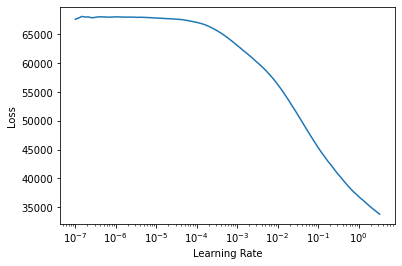

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


epoch,train_loss,valid_loss,l2_b_mean,mmd,mu,std,logvar,l1_b_mean,mu_sd,l1_latent_reg,weighted_kld,logvar_sd,time
0,35639.734375,33119.378906,32758.919922,354.753448,-0.645665,2.168537,1.389641,45340.976562,5.047215,5219.156250,18799.441406,0.807266,00:24
1,22419.580078,15466.881836,15300.407227,162.598511,-0.390403,2.085497,1.324767,30500.722656,3.677496,3760.603516,10589.691406,0.736531,00:23
2,14881.570312,10914.019531,10817.428711,94.298996,-0.218614,1.718532,0.952760,24908.886719,2.857116,2908.460693,6201.050781,0.693021,00:23
3,10775.079102,8509.122070,8455.727539,51.379539,-0.116926,1.412444,0.578432,21353.609375,2.194111,2228.759521,3532.319580,0.640258,00:24
4,8417.246094,7147.596680,7119.229980,26.634216,-0.072432,1.150160,0.179836,18936.121094,1.669925,1692.649536,1983.132935,0.602620,00:24
5,6787.373047,6221.455566,6203.451660,16.419044,-0.051861,0.946574,-0.200824,17108.943359,1.339317,1349.057983,1275.688110,0.569902,00:23
6,5708.291504,5401.690430,5387.585449,12.589787,-0.049178,0.882773,-0.334380,15516.946289,1.213070,1216.506592,1068.951294,0.555498,00:23
7,4967.996582,4810.905273,4799.205566,10.367170,-0.035553,0.831857,-0.451990,14039.386719,1.123102,1120.465332,946.840881,0.552006,00:24
8,4480.203613,4512.324219,4501.353516,9.820558,-0.032393,0.812645,-0.496762,13347.663086,1.094568,1089.507446,911.750488,0.546974,00:23
9,4122.484863,4195.836426,4185.203613,9.572933,-0.030994,0.816746,-0.486494,12404.958984,1.091210,1083.963379,904.418335,0.547605,00:24


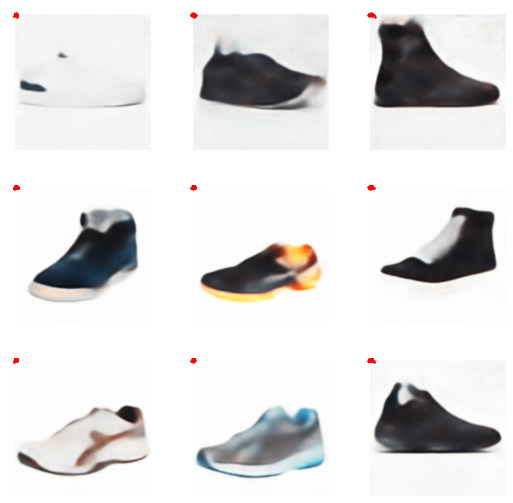

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'TMP'}-latent{latent_dim}"
filename = f"frozen-{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
#learn.export(f'{filename}.pkl')

Path('models/frozen-MMDVae-TMP-latent128-resblock-alpha10_2021-03-24_10.15.31.pth')

### 128 latents, alpha=20

In [ ]:
latent_dim = 128

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 20
# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=IMG_SIZE,out_range=OUT_RANGE)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    

(0.33113112449646,
 0.04786301031708717,
 0.18949706740677358,
 0.1258925348520279)

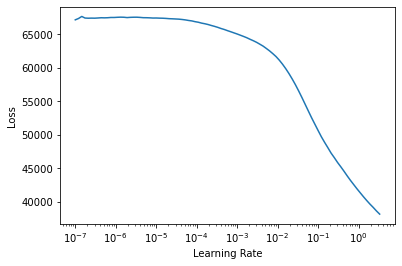

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


epoch,train_loss,valid_loss,l2_b_mean,mmd,mu,std,logvar,l1_b_mean,mu_sd,l1_latent_reg,weighted_kld,logvar_sd,time
0,44869.117188,38630.105469,38172.390625,452.347382,0.363450,2.003438,1.154238,49319.636719,4.148453,8080.807617,26520.181641,0.966020,00:23
1,28217.714844,19543.214844,19365.693359,173.174393,0.211772,1.590892,0.723334,34397.785156,2.722190,5338.421875,11395.580078,0.892636,00:23
2,18315.355469,13255.430664,13121.753906,130.631409,0.219888,1.532194,0.665691,27403.474609,2.465842,4917.343750,9348.974609,0.835872,00:23
3,12825.623047,9738.818359,9650.188477,86.012886,0.174977,1.367238,0.465474,22967.119141,2.081707,4158.813965,6535.408691,0.760577,00:24
4,9639.348633,7791.971191,7737.542480,52.770176,0.111142,1.187918,0.203920,20011.353516,1.711145,3402.236816,4313.964844,0.716786,00:24
5,7687.958496,6969.908203,6936.609375,31.604336,0.071600,1.017000,-0.096666,18651.474609,1.397718,2771.013672,2869.612793,0.689790,00:24
6,6420.611328,5956.696289,5929.208008,25.928036,0.055198,0.933785,-0.259582,16708.939453,1.273471,2517.689209,2402.669678,0.671029,00:24
7,5523.093750,5197.247559,5173.945801,21.902893,0.056021,0.890996,-0.346857,14908.278320,1.195464,2358.052979,2146.462646,0.652390,00:23
8,4918.751465,4908.517578,4887.394043,19.962851,0.048813,0.845242,-0.446389,13966.420898,1.135524,2239.118164,1974.152588,0.633212,00:24
9,4473.037598,4544.405762,4524.976074,18.338888,0.045379,0.825765,-0.490280,13264.149414,1.100679,2152.622803,1881.080322,0.627626,00:23


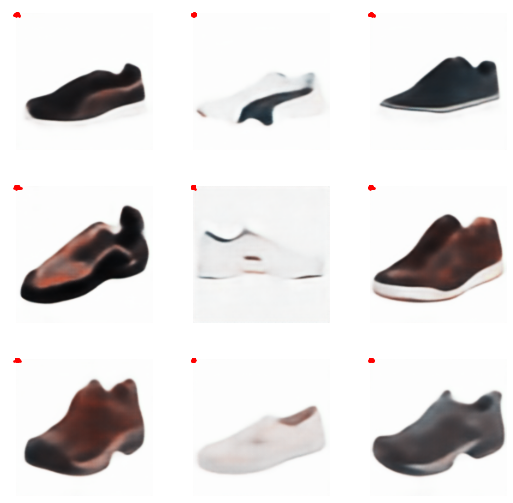

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'TMP'}-latent{latent_dim}"
filename = f"frozen-{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
#learn.export(f'{filename}.pkl')

Path('models/frozen-MMDVae-TMP-latent128-resblock-alpha20_2021-03-24_11.36.20.pth')

### 64 latents, alpha=10

In [ ]:
latent_dim = 64

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 10
# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=IMG_SIZE,out_range=OUT_RANGE)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    

(0.33113112449646,
 0.05754399299621582,
 0.1943375587463379,
 0.13803842663764954)

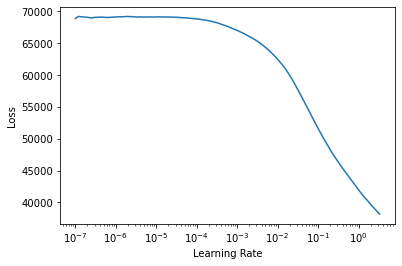

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


epoch,train_loss,valid_loss,l2_b_mean,mmd,mu,std,logvar,l1_b_mean,mu_sd,l1_latent_reg,weighted_kld,logvar_sd,time
0,43863.750000,38415.714844,38403.582031,4.531198,-0.005897,0.299329,-2.509599,52373.148438,0.443983,215.868622,578.306458,0.593813,00:24
1,29051.519531,25556.123047,25545.445312,6.811570,-0.004425,0.374405,-2.064293,41032.382812,0.560199,277.017273,490.831116,0.606257,00:23
2,20931.611328,19844.193359,19834.179688,7.637002,-0.004937,0.397987,-1.930601,35639.593750,0.592585,290.151154,466.145905,0.562413,00:24
3,14663.121094,12426.390625,12416.396484,8.592687,-0.002675,0.421610,-1.805782,27062.740234,0.626879,308.991547,445.806946,0.527288,00:24
4,10193.139648,9417.468750,9406.019531,10.110537,-0.011966,0.455588,-1.648575,22221.794922,0.682492,335.222321,429.319397,0.516746,00:23
5,7524.279785,6364.255859,6352.415039,10.702779,0.011146,0.471224,-1.580377,17584.408203,0.701387,342.728180,421.015381,0.519270,00:23
6,6115.612305,5585.450684,5572.469727,11.632233,-0.000796,0.494548,-1.479531,15968.841797,0.733156,358.945038,410.607941,0.503936,00:23
7,5255.900879,5021.166016,5008.228516,11.662443,-0.007470,0.507035,-1.426110,14532.230469,0.745946,364.898315,403.718201,0.487873,00:23
8,4705.863281,4692.226562,4679.104004,11.865071,0.000847,0.522057,-1.364778,13638.712891,0.759972,370.586456,396.001831,0.477372,00:24
9,4339.275391,4509.605469,4495.935059,12.448554,-0.006662,0.537097,-1.307204,13147.251953,0.781810,380.401398,393.854126,0.474533,00:23


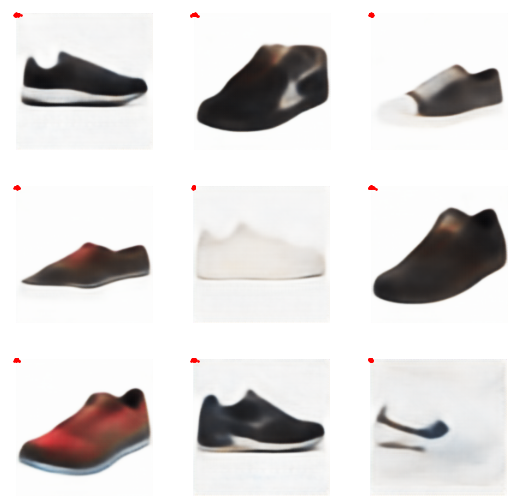

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'TMP'}-latent{latent_dim}"
filename = f"frozen-{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
#learn.export(f'{filename}.pkl')

Path('models/frozen-MMDVae-TMP-latent64-resblock-alpha10_2021-03-24_12.57.06.pth')

### 64 latents, alpha = 20

In [ ]:
latent_dim = 64

# cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
#                SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
#                ParamScheduler({'kl_weight': SchedNo(1.,1.) })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': SchedNo(1.,1.) })]

alpha = 20
# note that alpha needs to be adjusted to scale MMD regularizer compared to error for batchmean=true
#.  e.g.  *= 3*IMG_SIZE**2/latent_dim
batchmean = True
useL1 = False
hidden_dim = None

metrics = default_MMEVAE_metrics(alpha,batchmean,useL1)

batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resblock'
vae = ResBlockAE(get_resblockencoder_parts(arch), hidden_dim=hidden_dim,latent_dim=latent_dim,  im_size=IMG_SIZE,out_range=OUT_RANGE)
  
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMDLoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,
     
    
    

(0.33113112449646,
 0.03981071710586548,
 0.18547092080116273,
 0.11481534689664841)

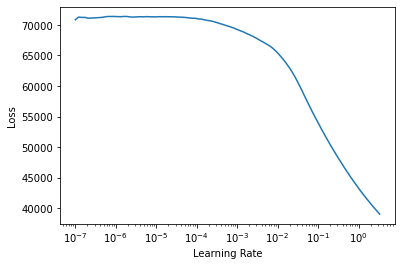

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


epoch,train_loss,valid_loss,l2_b_mean,mmd,mu,std,logvar,l1_b_mean,mu_sd,l1_latent_reg,weighted_kld,logvar_sd,time
0,40959.515625,37905.636719,37891.761719,8.208526,-0.024008,0.321359,-2.330088,51717.753906,0.548548,277.020477,558.442444,0.462210,00:23
1,28461.808594,31310.380859,31296.017578,11.071305,-0.001257,0.356824,-2.144540,45347.582031,0.634957,318.794250,540.526062,0.561912,00:24
2,20569.023438,24270.050781,24254.761719,12.098309,-0.021030,0.391993,-1.954344,39474.792969,0.675133,337.234344,506.135071,0.548326,00:23
3,14445.319336,15024.644531,15008.929688,13.079365,-0.020070,0.419365,-1.815197,30104.261719,0.710429,353.417725,484.618500,0.530492,00:24
4,10298.541016,9405.922852,9392.183594,12.310252,-0.012689,0.445155,-1.688505,22990.738281,0.714922,355.908539,453.056366,0.504430,00:24
5,7728.354980,6665.394531,6650.482422,13.403973,-0.013079,0.452304,-1.656670,18389.359375,0.737011,364.198914,455.659149,0.502500,00:23
6,6190.182129,5603.939941,5589.669434,12.933229,-0.013793,0.479955,-1.534696,15767.240234,0.748866,369.001404,430.846649,0.491857,00:23
7,5236.472656,5212.584961,5196.565430,14.607766,-0.016758,0.491669,-1.485687,14362.958984,0.785005,385.483612,437.185181,0.486615,00:23
8,4617.360840,4473.277344,4458.379395,14.115689,-0.030596,0.498461,-1.451891,12745.385742,0.778319,385.171143,424.746368,0.459398,00:23
9,4208.974609,4216.414551,4200.229004,15.131713,-0.027884,0.513088,-1.392592,11635.668945,0.803424,394.603180,423.435181,0.455078,00:23


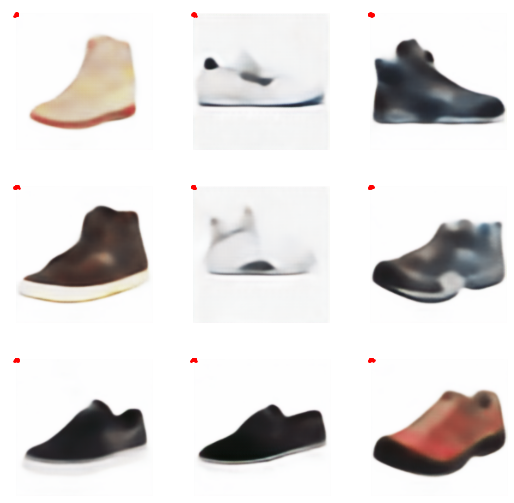

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
#learn.freeze()
n_epoch = 200
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch)#, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch,lr_max=gmlr) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'TMP'}-latent{latent_dim}"
filename = f"frozen-{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
#learn.export(f'{filename}.pkl')

Path('models/frozen-MMDVae-TMP-latent64-resblock-alpha10_2021-03-24_14.17.51.pth')

## vanilla-resnet beta-VAE

In [ ]:
class ResBlockBVAE(BVAE):
    """
    simple VAE with a _probably_ pretrained encoder 
    """

    def __init__(self,enc_parts,hidden_dim=None, latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE):
       
        """
        inputs:  
            enc_arch (pre-cut / pretrained)
            enc_dim
            latent_dim
            hidden_dim
            im_size,out_range
        """
        enc_arch,enc_feats,name = enc_parts

        # encoder
        #  arch,cut = xresnet18(pretrained=True),-4
        #  enc_arch = list(arch.children())[:cut]
        
        BASE = im_size//2**5
        enc_dim = enc_feats * BASE**2  # 2**(3*3) * (im_size//32)**2 #(output of resneet) #12800

        self.encoder = build_AE_encoder(enc_arch,enc_dim=enc_dim, hidden_dim=hidden_dim, im_size=im_size)

        in_dim = enc_dim if hidden_dim is None else hidden_dim

        # VAE Bottleneck
        self.bn = VAELayer(in_dim,latent_dim)     

        #decoder
        self.decoder = build_ResBlockAE_decoder(hidden_dim=hidden_dim, latent_dim=latent_dim, im_size=im_size,out_range=out_range)

        store_attr('name,enc_dim, in_dim,hidden_dim,latent_dim,im_size,out_range') # do i need all these?




#  THESE ARE INHERITED..
#     def decode(self, z):    
#         z = self.decoder(z)
#         return z
    
#     def reparam(self, h):
#         return self.bn(h)

#     def encode(self, x):
#         h = self.encoder(x)
#         z, mu, logvar = self.reparam(h)
#         return z, mu, logvar

#     def forward(self, x):
#         z, mu, logvar = self.encode(x)
#         x_hat = self.decode(z)
#         latents = torch.stack([mu,logvar],dim=-1)
#         return x_hat, latents # assume dims are [batch,latent_dim,concat_dim]
        
        
        

### 128 latents, alpha=5

In [ ]:
latent_dim = 128
alpha = 5 # doubled because latent is half?
batchmean = True
useL1 = False

# SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True), 
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ParamScheduler({'kl_weight':  SchedNo(1.,1.) })]


metrics = default_VAE_metrics(alpha,batchmean,useL1)


block = get_ae_DataBlock(aug=True)
batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resnblock'
vae = ResBlockBVAE(get_resblockencoder_parts(arch), hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE)
                   
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = BVAELoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,



(0.0001737800776027143,
 0.0012022644514217973,
 0.0006880222645122558,
 0.0004570883756969124)

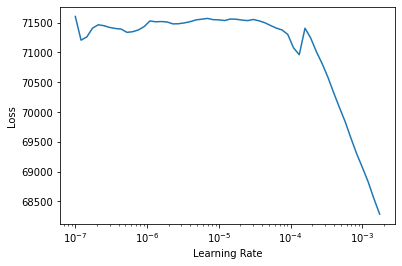

In [ ]:
# NOTE: lf_finder does NOT work correctly with our annealed kl_weight... 

lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
#put in the annealied KL_weight...
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight': default_KL_anneal_in()} ) )

#fit the backend of the VAE (n)
# the defaults are pretty good for now
n_epochs = 10

#learn.fit_one_cycle(freeze_epochs1,lr_max= lr1)#, lr_max= base_lr)
#learn.fit_flat_cos(n_epochs, lr=lr1, pct_start=0.5)
#learn.fit_flat_cos(n_epochs) #, lr=1e-4,pct_start=0.5)
learn.fit_one_cycle(n_epochs)#, lr_max= base_lr)

learn.show_results()


This initial "burning in" of the KLD regularization is very unstable...

In [ ]:
# replace kl_weight scheduler... with a constant unity... (NOTE: should be robust to failure if we don't replace it)
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight':  SchedNo(1.,1.) }) )

#learn.unfreeze()


(6.309573450380412e-08,
 1.5848931980144698e-06,
 8.239944662591369e-07,
 3.162276129842212e-07)

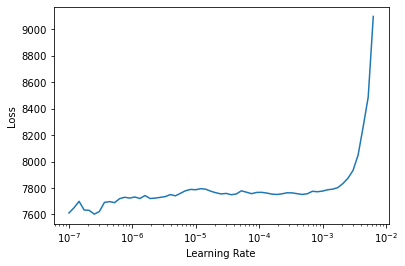

In [ ]:

lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,7446.696289,7002.534668,6594.965820,-0.056031,0.609424,-1.249221,406.261200,1.000000,16749.544922,0.762242,0.250232,1.164957,00:24
1,6559.509766,6201.054688,5791.714844,-0.041461,0.618311,-1.230625,408.183350,1.000000,14291.185547,0.769989,0.256279,1.197002,00:24
2,5965.905762,5736.044434,5315.900879,-0.065841,0.617567,-1.259662,419.067261,1.000000,13115.260742,0.771636,0.256352,1.277502,00:24
3,5546.066406,5484.937012,5098.352539,-0.031883,0.655282,-1.149140,385.752136,1.000000,12599.239258,0.741821,0.269175,1.304524,00:23
4,5216.171387,5357.946289,4967.701172,-0.048715,0.659577,-1.167782,389.449951,1.000000,11821.793945,0.728742,0.278477,1.384185,00:24
5,4968.410156,4974.411133,4575.067383,-0.037054,0.655091,-1.190241,398.651703,1.000000,11053.794922,0.738295,0.278551,1.407455,00:24
6,4758.382812,4930.711914,4530.911133,-0.042303,0.655234,-1.206222,399.300415,1.000000,10765.223633,0.727668,0.281477,1.447791,00:24
7,4598.325684,4773.492188,4384.264648,-0.028840,0.662661,-1.158184,388.670288,1.000000,10158.075195,0.732503,0.278200,1.385599,00:24
8,4481.006348,4676.386719,4256.562988,-0.047947,0.652907,-1.256124,419.240143,1.000000,9864.458008,0.734679,0.288794,1.560645,00:24
9,4396.450195,4542.811035,4142.692871,-0.031679,0.664870,-1.194383,399.589661,1.000000,9653.433594,0.725160,0.288026,1.493910,00:23


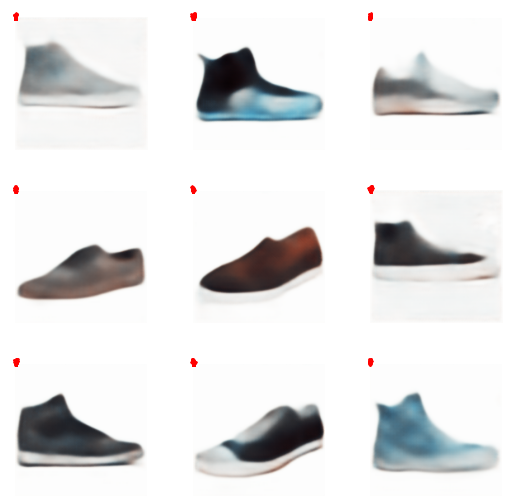

In [ ]:
#epochs = 5
base_lr = 1e-5# gmlr #/= 2
epochs = 100

#learn.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div)
#learn.fit_one_cycle(epochs, lr_max= 1e-3)
#learn.fit_flat_cos(epochs,lr=lr1,pct_start=.05)
learn.fit_flat_cos(epochs,div_final=1000)#,lr=1e-4)
learn.show_results()

In [ ]:
prefix = f"BVae-{'2step10_100'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

In [ ]:
x = 1

### 128 latents, alpha=10

In [ ]:
latent_dim = 128
alpha = 10 # doubled because latent is half?
batchmean = True
useL1 = False



# SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True), 
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ParamScheduler({'kl_weight':  SchedNo(1.,1.) })]


metrics = default_VAE_metrics(alpha,batchmean,useL1)


block = get_ae_DataBlock(aug=True)
batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resnblock'
vae = ResBlockBVAE(get_resblockencoder_parts(arch), hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE)
                   
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = BVAELoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,



(0.00043651582673192023,
 0.002511886414140463,
 0.0014742011204361915,
 0.001047128695063293)

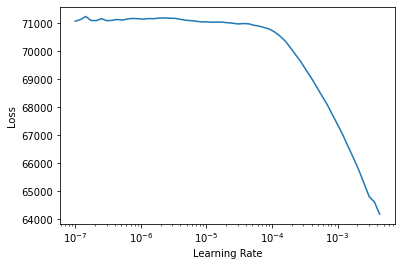

In [ ]:
# NOTE: lf_finder does NOT work correctly with our annealed kl_weight... 

lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
#put in the annealied KL_weight...
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight': default_KL_anneal_in()} ) )

In [ ]:
# #fit the backend of the VAE (n)
# # the defaults are pretty good for now
n_epochs = 10

learn.fit_one_cycle(n_epochs)#, lr_max= base_lr)
# #learn.fit_flat_cos(n_epochs, lr=lr1, pct_start=0.5)
# learn.fit_flat_cos(n_epochs, lr=1e-4,pct_start=0.5)

# learn.show_results()


epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,57119.871094,48978.390625,48411.449219,-0.171113,0.467323,-1.606784,11681.308594,0.047932,57218.921875,4.143692,0.132895,0.589939,00:25
1,42990.976562,33256.042969,32888.765625,-0.111939,0.787082,-0.534524,1944.819458,0.185387,45751.316406,1.667504,0.184117,0.476903,00:25
2,27649.550781,18003.472656,17567.388672,-0.051287,0.614378,-1.090928,1118.868530,0.385156,32650.421875,1.105906,0.211503,0.686238,00:25
3,18592.869141,13246.469727,12702.623047,-0.040173,0.588392,-1.146373,889.270142,0.607671,27025.304688,0.926397,0.170838,0.591538,00:25
4,13824.781250,11302.725586,10674.322266,-0.025407,0.626357,-1.017098,773.015381,0.808860,24171.271484,0.872669,0.170972,0.585883,00:25
5,11246.221680,9732.048828,9055.437500,0.002667,0.623677,-1.060219,710.477600,0.948876,21821.728516,0.787523,0.195109,0.716930,00:25
6,9790.408203,9052.549805,8347.827148,0.037016,0.624793,-1.088983,702.386963,0.999986,20620.949219,0.755349,0.210199,0.831470,00:25
7,8893.800781,8546.672852,7901.442383,0.032866,0.649115,-1.026540,642.988525,1.000000,19937.876953,0.710113,0.222703,0.880089,00:25
8,8421.801758,8350.280273,7711.315918,0.032067,0.647427,-1.042604,636.768677,1.000000,19623.410156,0.692194,0.226795,0.915346,00:25
9,8228.472656,8303.927734,7656.038574,0.032340,0.642907,-1.063508,645.732849,1.000000,19511.349609,0.690796,0.228713,0.935445,00:25


In [ ]:
# #fit the backend of the VAE (n)
# # the defaults are pretty good for now
# n_epochs = 10

# learn.fit_one_cycle(10)#, lr_max= base_lr)
# #learn.fit_flat_cos(n_epochs, lr=lr1, pct_start=0.5)
# #learn.fit_flat_cos(n_epochs, lr=1e-4,pct_start=0.5)

# learn.show_results()


This initial "burning in" of the KLD regularization is very unstable...

In [ ]:
# replace kl_weight scheduler... with a constant unity... (NOTE: should be robust to failure if we don't replace it)
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight':  SchedNo(1.,1.) }) )

#learn.unfreeze()


(6.918309954926372e-05,
 1.4454397387453355e-05,
 4.181874846835854e-05,
 3.16227633447852e-05)

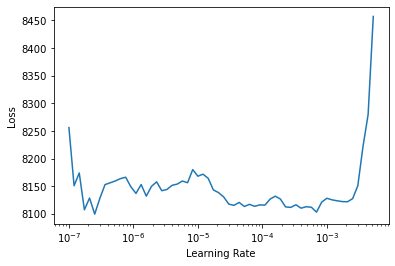

In [ ]:

lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,7636.996094,7720.530273,7083.126953,0.019008,0.683685,-0.985189,635.105652,1.000000,17760.312500,0.687582,0.255679,1.082731,00:26
1,6885.542480,6894.079590,6297.856445,0.006627,0.707549,-0.936249,594.373535,1.000000,16222.292969,0.647742,0.266870,1.149313,00:25
2,6309.057617,6247.788574,5663.020508,0.013977,0.733179,-0.899275,583.153992,1.000000,14961.074219,0.627324,0.282289,1.256484,00:25
3,5862.837891,5824.015137,5272.883301,0.018640,0.760227,-0.806429,549.852478,1.000000,13915.848633,0.627636,0.282030,1.206542,00:25
4,5524.013672,5580.453613,4991.576660,0.000202,0.744082,-0.900245,587.568359,1.000000,13173.700195,0.615521,0.290766,1.348567,00:25
5,5247.176758,5352.265625,4772.904785,0.012758,0.746673,-0.887565,578.224121,1.000000,12680.643555,0.611426,0.288877,1.332583,00:25
6,5000.711914,5149.272949,4567.143555,0.021369,0.757468,-0.872349,581.102356,1.000000,12148.317383,0.609617,0.297950,1.367787,00:25
7,4822.857422,4957.025879,4346.383789,0.012121,0.743142,-0.944743,609.705933,1.000000,11592.447266,0.603416,0.300536,1.456099,00:25
8,4670.200195,4811.929199,4201.861328,0.023626,0.744356,-0.943792,609.286682,1.000000,11109.132812,0.600485,0.303331,1.457995,00:25
9,4552.351562,4701.762207,4124.187012,0.012166,0.752433,-0.885569,576.840942,1.000000,10700.002930,0.601379,0.294862,1.367969,00:25


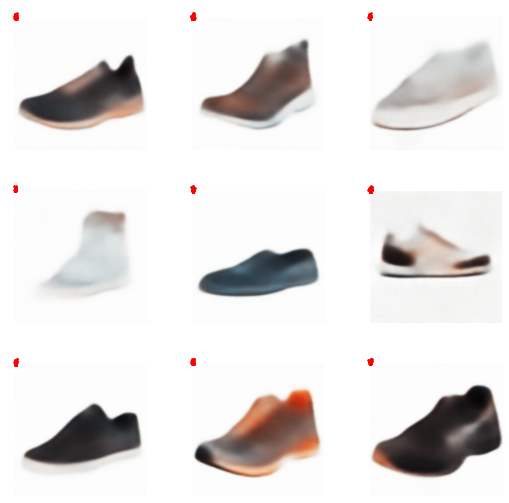

In [ ]:
#epochs = 5
epochs = 100

#learn.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div)
#learn.fit_one_cycle(epochs, lr_max= 1e-3)
#learn.fit_flat_cos(epochs,lr=lr1,pct_start=.05)
learn.fit_flat_cos(epochs,div_final = 1000)#,lr=1e-4)
learn.show_results()

In [ ]:
learn.lr


0.001

In [ ]:
# prefix = f"BVae-{'POST-1CYCLE10'}-latent{latent_dim}"
# filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

# learn.save(filename)
# learn.export(f'{filename}.pkl')

In [ ]:
# #epochs = 5
# base_lr = 1e-5# gmlr #/= 2
# epochs = 50

# #learn.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div)
# #learn.fit_one_cycle(epochs, lr_max= 1e-3)
# #learn.fit_flat_cos(epochs,lr=lr1,pct_start=.05)
# learn.fit_flat_cos(epochs)
# learn.show_results()

In [ ]:
# prefix = f"BVae-{'POST-1CYCLE10-COS50'}-latent{latent_dim}"
# filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

# learn.save(filename)
# learn.export(f'{filename}.pkl')

In [ ]:
# prefix = f"BVae-{'POST-1CYCLE10'}-latent{latent_dim}"
# filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"
# filename = "BVae-POST-1CYCLE10-latent128-resblock-alpha10_2021-03-24_21.33.02"
# learn.load(filename)
# #epochs = 5
# epochs = 10
# learn.fit_one_cycle(epochs, lr_max=.001)
# #learn.fit_flat_cos(epochs,lr=.0015,pct_start=.5,div_final=1000.0)
# #learn.fit_one_cycle(epochs,lr_max=5e-3,pct_start=0.5,div_final=100000) # gets down to ~4500 loss in 10
# learn.show_results()

In [ ]:
prefix = f"BVae-{'2step10_100'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

### 64 latents, alpha=5

In [ ]:
latent_dim = 64
alpha = 5 # doubled because latent is half?
batchmean = True
useL1 = False


# SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True), 
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ParamScheduler({'kl_weight':  SchedNo(1.,1.) })]


metrics = default_VAE_metrics(alpha,batchmean,useL1)


block = get_ae_DataBlock(aug=True)
batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resnblock'
vae = ResBlockBVAE(get_resblockencoder_parts(arch), hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE)
                   
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = BVAELoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,



(0.0002511886414140463,
 0.0030199517495930195,
 0.0016355701955035329,
 0.0008709632093086839)

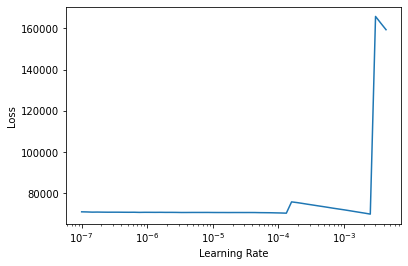

In [ ]:
# NOTE: lf_finder does NOT work correctly with our annealed kl_weight... 

lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
#put in the annealied KL_weight...
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight': default_KL_anneal_in()} ) )

epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,62175.605469,58420.937500,58348.890625,-0.051949,0.756474,-0.705867,1368.726318,0.047932,61588.308594,1.822992,0.582341,0.659328,00:25
1,49618.242188,39473.527344,39206.046875,-0.043057,0.851662,-0.396860,1403.989502,0.185387,52113.386719,2.003324,0.221583,0.661778,00:25
2,38106.187500,29982.267578,29626.966797,-0.051806,0.686124,-1.142172,902.552917,0.385156,45277.328125,1.447544,0.294982,2.087242,00:25
3,31850.349609,25701.712891,25034.757812,-0.007050,0.893151,-0.651888,1084.826294,0.607671,40963.800781,1.650774,0.426548,1.889337,00:25
4,26937.095703,22336.453125,21880.179688,-0.020213,0.755051,-0.904856,554.679199,0.808860,37525.218750,1.066666,0.338944,1.718830,00:25
5,21971.119141,18084.140625,17574.322266,0.022983,0.661450,-1.064209,531.471375,0.948876,32476.261719,1.040300,0.269217,1.212421,00:25
6,17252.421875,14166.872070,13769.662109,-0.004297,0.650027,-1.045775,395.191437,0.999986,27589.769531,0.842583,0.236650,1.021509,00:25
7,13777.228516,12127.618164,11719.044922,-0.000522,0.590726,-1.253758,407.167450,1.000000,24565.738281,0.784295,0.232350,1.025303,00:25
8,12025.313477,11425.287109,11027.707031,-0.002325,0.577320,-1.306436,396.206085,1.000000,23534.054688,0.737082,0.233305,1.023820,00:25
9,11348.297852,11215.250977,10807.715820,-0.002401,0.565716,-1.354919,405.828369,1.000000,23167.085938,0.733784,0.232911,1.041644,00:25


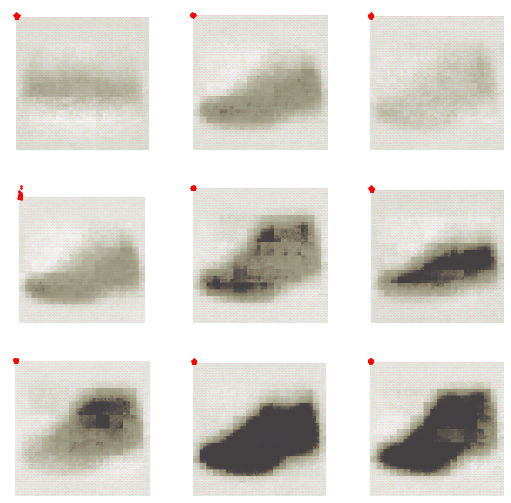

In [ ]:
# the defaults are pretty good for now
n_epochs = 10

learn.fit_one_cycle(n_epochs)#,lr_max= lr1)#, lr_max= base_lr)
#learn.fit_flat_cos(n_epochs, lr=lr1, pct_start=0.5)
#learn.fit_flat_cos(n_epochs, lr=1e-4,pct_start=0.5)

learn.show_results()


This initial "burning in" of the KLD regularization is very unstable...

In [ ]:
# replace kl_weight scheduler... with a constant unity... (NOTE: should be robust to failure if we don't replace it)
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight':  SchedNo(1.,1.) }) )

#learn.unfreeze()


(5.754399353463669e-07,
 2.2908675418875646e-06,
 1.4331537386169657e-06,
 1.1481544106572983e-06)

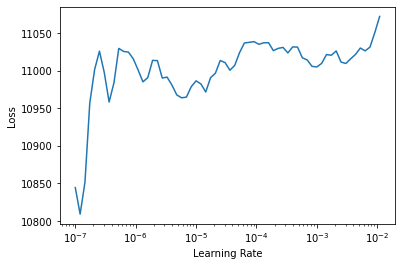

In [ ]:

lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,9465.326172,9999.078125,9601.225586,0.007130,0.609639,-1.205733,396.314056,1.000000,21853.699219,0.774112,0.246161,1.020246,00:26
1,8063.734375,7810.102051,7418.045410,-0.010892,0.615129,-1.217685,390.613068,1.000000,17732.515625,0.748079,0.253269,1.108232,00:25
2,7098.869141,6891.984375,6494.851074,0.003510,0.620044,-1.240355,395.655640,1.000000,15703.275391,0.735949,0.262632,1.223647,00:25
3,6485.855469,6270.389648,5868.511719,-0.005693,0.648472,-1.133566,400.792297,1.000000,13933.801758,0.791065,0.267172,1.181391,00:25
4,5972.832520,5844.192871,5451.658691,0.012890,0.644426,-1.175375,391.558289,1.000000,13166.174805,0.748259,0.268520,1.273546,00:25
5,5572.884766,5628.988281,5244.474121,0.007183,0.655677,-1.138401,383.767944,1.000000,12375.596680,0.746120,0.270278,1.270705,00:25
6,5250.625977,5428.687500,5025.041504,0.000618,0.657387,-1.176482,402.747681,1.000000,12075.447266,0.754705,0.281650,1.383355,00:25
7,4992.806152,5028.703125,4640.528320,0.009451,0.677483,-1.110796,387.616364,1.000000,11064.332031,0.747032,0.286410,1.379216,00:25
8,4797.666016,4977.150879,4576.464844,-0.004673,0.662541,-1.180220,399.917969,1.000000,10845.199219,0.740392,0.284689,1.444876,00:25
9,4619.204590,4714.991211,4327.709961,-0.004181,0.676296,-1.131910,386.741913,1.000000,10164.172852,0.729932,0.291930,1.414375,00:25


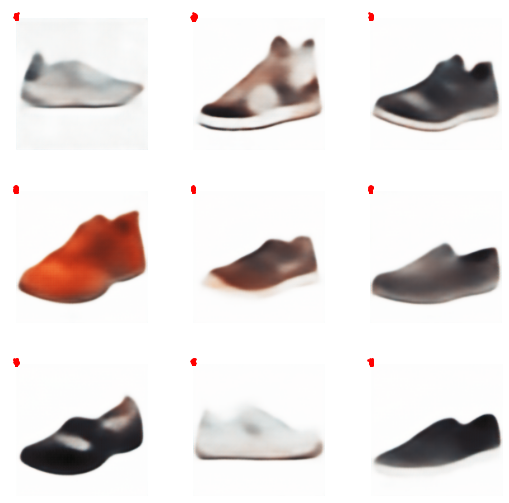

In [ ]:
#epochs = 5
base_lr = 1e-5# gmlr #/= 2
epochs = 100

#learn.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div)
#learn.fit_one_cycle(epochs, lr_max= 1e-3)
#learn.fit_flat_cos(epochs,lr=lr1,pct_start=.05)
#learn.fit_flat_cos(epochs,lr=1e-4)
learn.fit_flat_cos(epochs, div_final=1000.0)#,lr=1e-3)
learn.show_results()

In [ ]:
prefix = f"BVae-{'2step10_100'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

### 64 latents, alpha=10

In [ ]:
latent_dim = 64
alpha = 10 # doubled because latent is half?
batchmean = True
useL1 = False


# SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True), 
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ParamScheduler({'kl_weight':  SchedNo(1.,1.) })]


metrics = default_VAE_metrics(alpha,batchmean,useL1)


block = get_ae_DataBlock(aug=True)
batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

arch='resnblock'
vae = ResBlockBVAE(get_resblockencoder_parts(arch), hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE)
                   
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = BVAELoss(batchmean=batchmean,alpha=alpha,useL1=False)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=AE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,



(0.00043651582673192023,
 0.00363078061491251,
 0.002033648220822215,
 0.0012589251855388284)

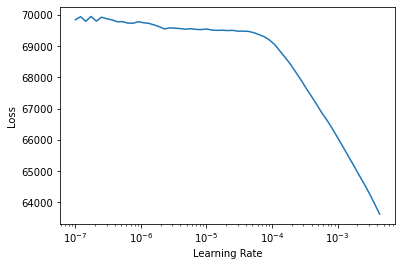

In [ ]:
# NOTE: lf_finder does NOT work correctly with our annealed kl_weight... 

lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
#put in the annealied KL_weight...
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight': default_KL_anneal_in()} ) )

epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,58740.539062,55176.195312,54889.167969,0.120437,0.523871,-1.432346,5821.192383,0.047932,60959.058594,2.827253,0.179028,0.830196,00:25
1,45920.312500,32378.673828,32121.812500,-0.037095,0.680219,-0.876800,1361.199707,0.185387,44998.371094,1.317362,0.198534,0.791697,00:25
2,28567.009766,18783.580078,18389.089844,-0.023480,0.572010,-1.268163,1013.169067,0.385156,32817.027344,0.967404,0.211317,0.809108,00:26
3,19321.156250,13977.159180,13471.999023,-0.019137,0.579537,-1.282815,827.127136,0.607671,27876.337891,0.787131,0.226196,0.940032,00:25
4,14469.906250,12062.826172,11523.424805,-0.031412,0.642168,-1.077186,664.454651,0.808860,25497.568359,0.700015,0.236848,0.963814,00:25
5,11711.579102,10398.442383,9849.642578,-0.026665,0.686315,-0.960859,576.726868,0.948876,23399.960938,0.636489,0.249260,1.035778,00:25
6,10033.545898,9363.882812,8784.699219,-0.025187,0.691321,-0.990074,577.364075,0.999986,21912.365234,0.602564,0.263317,1.168671,00:25
7,9010.625977,8700.817383,8128.997070,-0.021991,0.701658,-0.985699,570.353088,1.000000,21030.861328,0.579129,0.276201,1.233390,00:25
8,8411.709961,8434.400391,7861.457031,-0.025626,0.711409,-0.979375,571.588013,1.000000,20555.650391,0.569511,0.285582,1.291906,00:25
9,8147.944824,8266.574219,7697.082031,-0.025811,0.712803,-0.977301,568.101562,1.000000,20270.447266,0.564367,0.286426,1.297384,00:26


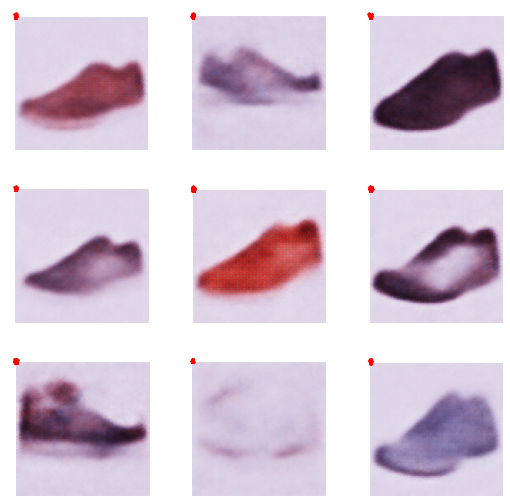

In [ ]:
#fit the backend of the VAE (n)
# the defaults are pretty good for now
n_epochs = 10

learn.fit_one_cycle(n_epochs)#,lr_max= lr1)#, lr_max= base_lr)
#learn.fit_flat_cos(n_epochs, lr=lr1, pct_start=0.5)
#learn.fit_flat_cos(n_epochs, lr=1e-4,pct_start=0.5)

learn.show_results()


This initial "burning in" of the KLD regularization is very unstable...

In [ ]:
# replace kl_weight scheduler... with a constant unity... (NOTE: should be robust to failure if we don't replace it)
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
learn.add_cb(ParamScheduler({'kl_weight':  SchedNo(1.,1.) }) )

#learn.unfreeze()


(6.309573450380412e-08,
 1.9054607491852948e-06,
 9.842782418445494e-07,
 3.467365559117752e-07)

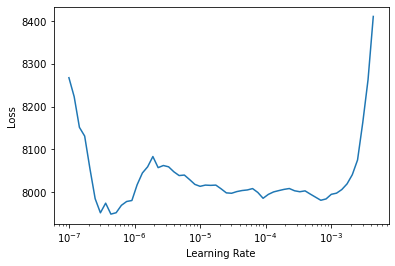

In [ ]:

lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


epoch,train_loss,valid_loss,l2_b_mean,mu,std,logvar,weighted_kld,kl_weight,l1_b_mean,mu_sd,std_sd,logvar_sd,time
0,7651.367676,7365.542969,6727.640625,-0.001503,0.707371,-0.946704,636.378296,1.000000,18033.966797,0.688343,0.267682,1.189982,00:28
1,6716.003906,6474.808594,5877.452637,-0.036604,0.720139,-0.926342,595.863586,1.000000,16393.494141,0.638700,0.274323,1.235185,00:28
2,5997.029297,5860.405273,5274.698242,-0.018035,0.736100,-0.887804,584.582947,1.000000,15014.263672,0.634403,0.281981,1.247762,00:28
3,5485.274414,5364.577148,4783.366699,-0.004125,0.744810,-0.855897,580.197937,1.000000,13838.269531,0.644898,0.280916,1.228757,00:28
4,5094.323730,5222.379883,4581.991699,0.001645,0.730681,-0.953955,639.444214,1.000000,13211.501953,0.650297,0.294958,1.385436,00:28
5,4805.841309,4832.098145,4243.259277,-0.007232,0.739415,-0.903473,588.059143,1.000000,12172.434570,0.618609,0.291089,1.310845,00:28
6,4583.566406,4695.562012,4069.434326,0.008616,0.726104,-0.973470,625.385925,1.000000,11474.740234,0.621857,0.297524,1.394230,00:28
7,4416.959961,4745.934570,4140.187012,0.001199,0.740462,-0.918071,604.966614,1.000000,11435.058594,0.623564,0.298082,1.354706,00:28
8,4314.148438,4493.190918,3870.912598,-0.005136,0.733318,-0.939494,621.700745,1.000000,10547.795898,0.636232,0.296641,1.357139,00:28
9,4209.107910,4406.982422,3759.320068,-0.001849,0.727758,-1.000237,647.177917,1.000000,10461.577148,0.620679,0.307983,1.468478,00:28


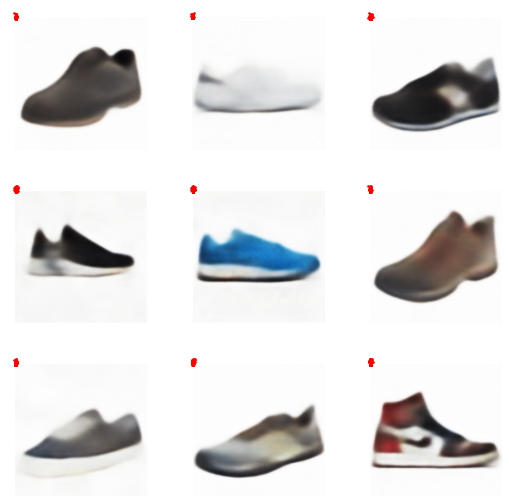

In [ ]:
#epochs = 5
base_lr = 1e-5# gmlr #/= 2
epochs = 100

#learn.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div)
#learn.fit_one_cycle(epochs, lr_max= 1e-3)
#learn.fit_flat_cos(epochs,lr=lr1,pct_start=.05)
learn.fit_flat_cos(epochs,div_final=1000.)
learn.show_results()

In [ ]:
prefix = f"BVae-{'2step10_100'}-latent{latent_dim}"
filename = f"{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

## CODE graveyard 

In [ ]:
# not using...
class LatentTuple(fastuple):
    "Basic type for tuple of tensor (vectors)"
    _show_args = dict(s=10, marker='.', c='r')
    @classmethod
    def create(cls, ts): 
        if isinstance(ts,tuple):
            mu,logvar = ts
        elif ts is None:
            mu,logvar = None,None
        else:
            mu = None
            logvar = None
            
        if mu is None: mu = torch.empty(0)
        elif not isinstance(mu, Tensor): Tensor(mu) 
        
        if logvar is None: logvar = torch.empty(0)
        elif not isinstance(logvar,Tensor): Tensor(logvar)
            
        return cls( (mu,logvar) ) 
        
    def show(self, ctx=None, **kwargs): 
        mu,logvar = self
        if not isinstance(mu, Tensor) or not isinstance(logvar,Tensor): return ctx

        title_str = f"mu-> {mu.mean():e}, {mu.std():e}  logvar->{logvar.mean():e}, {logvar.std():e}"
    
        if 'figsize' in kwargs: del kwargs['figsize']
        if 'title' in kwargs: kwargs['title']=title_str
        if ctx is None:
            _,axs = plt.subplots(1,2, figsize=(12,6))
            x=torch.linspace(0,1,mu[0].shape[0])
            axs[0].scatter(x, mu[:], **{**self._show_args, **kwargs})
            axs[1].scatter(x, logvar[:], **{**self._show_args, **kwargs})
            ctx = axs[1]
        
        ctx.scatter(mu[:], logvar[:], **{**self._show_args, **kwargs})
        return ctx
    
# could we do a typedispatch to manage the transforms...?
def VAETargetTupleBlock(): 
    return TransformBlock(type_tfms=VAETargetTuple.create, batch_tfms=IntToFloatTensor)

def LatentTupleBlock(): 
    return TransformBlock(type_tfms=LatentTuple.create, batch_tfms=noop)
    

# class TensorPoint(TensorBase):
#     "Basic type for points in an image"
#     _show_args = dict(s=10, marker='.', c='r')

#     @classmethod
#     def create(cls, t, img_size=None)->None:
#         "Convert an array or a list of points `t` to a `Tensor`"
#         return cls(tensor(t).view(-1, 2).float(), img_size=img_size)

#     def show(self, ctx=None, **kwargs):
#         if 'figsize' in kwargs: del kwargs['figsize']
#         x = self.view(-1,2)
#         ctx.scatter(x[:, 0], x[:, 1], **{**self._show_args, **kwargs})
#         return ctx



In [ ]:
latent_dim = 128
dropout = .2
im_size = IMG_SIZE
n_blocks = 5        
nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
nfs.reverse()
# decoder = nn.Sequential(
#             nn.Linear(latent_size, 16),
#             UnFlatten(4),
#             ResBlock(1, 3, 4, act_cls=Mish),
#             nn.Dropout2d(dropout),
#             nn.Upsample(scale_factor=2),
#             ResBlock(1, 4, 8, act_cls=Mish),
#             nn.Dropout2d(dropout),
#             nn.Upsample(scale_factor=2),
#             ResBlock(1, 8, 16, act_cls=Mish),
#             nn.Dropout2d(dropout),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(16, 1, 3),
#             nn.Dropout2d(dropout),
#             #nn.AdaptiveAvgPool2d((3,im_size, im_size)) 
# )





n_blocks = 5
hidden_dim = 2048
out_range = [-1,1]
tst = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim), #nn.Linear(latent_dim, 16)
            nn.Linear(hidden_dim,im_size*n_blocks*n_blocks), #nn.Linear(latent_dim, 16)
            ResizeBatch(im_size,n_blocks,n_blocks),#UnFlatten(n_blocks), #4
            ResBlock(1, nfs[0], nfs[1], act_cls=Mish), #ResBlock(1, 1, 4, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[1], nfs[2], act_cls=Mish), #RResBlock(1, 4, 8, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[2], nfs[3], act_cls=Mish), #ResBlock(1, 8, 16, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[3], nfs[4], act_cls=Mish), #nn.Conv2d(16, 1, 3),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[4], nfs[5], act_cls=Mish), #nn.Conv2d(16, 1, 3),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[5], nfs[6], act_cls=Mish), #nn.Conv2d(16, 1, 3),
            #nn.Dropout2d(dropout),
            #nn.Upsample(scale_factor=2),            #
            #nn.AdaptiveAvgPool2d((3,im_size, im_size)),
            SigmoidRange(*out_range), #nn.Sigmoid()
)
tst,nfs

In [ ]:
inp=    torch.randn((32,latent_dim))
#last_size = model_sizes(tst ) #[-1][1]
#num_features_model(tst)
#last_size
#nfs
tst(inp).shape,nfs
#last_size

In [ ]:
z_dim = 100
enc = nn.Sequential(
    ResBlock(1, 1, 16, act_cls=nn.ReLU, norm_type=None),
    nn.MaxPool2d(2, 2),
    ResBlock(1, 16, 4, act_cls=nn.ReLU, norm_type=None),
    nn.MaxPool2d(2, 2),
    Flatten()
)
# torch.Size([32, 1, 28, 28])
# torch.Size([32, 16, 28, 28])
# torch.Size([32, 16, 14, 14])
# torch.Size([32, 4, 14, 14])
# torch.Size([32, 4, 7, 7])
# torch.Size([32, 196])

latent_size = 100

enc = nn.Sequential(
            ResBlock(1, 3, 5, stride=2, act_cls=Mish),#  1->3
            ResBlock(1, 5, 5, stride=2, act_cls=Mish),
            ResBlock(1, 5, 1, stride=2, act_cls=Mish),
            Flatten(),
            nn.Linear(400, latent_size) # 16->400
        )
#  torch.Size([32, 1, 28, 28])
# torch.Size([32, 5, 14, 14])
# torch.Size([32, 5, 7, 7])
# torch.Size([32, 1, 4, 4])
# torch.Size([32, 16])
# torch.Size([32, 4])       
inp=    torch.randn((32,3,160,160))
for ii in range(0,8):
    print(enc[:ii](inp).shape)

z = enc(inp)


In [ ]:
dropout=0
dec = nn.Sequential(
            nn.Linear(latent_size, 16),
            UnFlatten(4),
            ResBlock(1, 1, 4, act_cls=Mish), #4->5
            #nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, 4, 8, act_cls=Mish),
            #nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, 8, 16, act_cls=Mish),
            #nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 3, 3), #1->3
            #nn.Dropout2d(dropout),
            nn.AdaptiveAvgPool2d((28, 28)),
            nn.Sigmoid()
        )

# torch.Size([32, 4])
# torch.Size([32, 16])
# torch.Size([32, 1, 4, 4])
# torch.Size([32, 4, 4, 4])
# torch.Size([32, 4, 8, 8])
# torch.Size([32, 8, 8, 8])
# torch.Size([32, 8, 16, 16])
# torch.Size([32, 16, 16, 16])
# torch.Size([32, 16, 32, 32])
# torch.Size([32, 1, 30, 30])
# torch.Size([32, 1, 28, 28])


for ii in range(0,12):
    print(dec[:ii](z).shape)

In [ ]:
n_blocks = 5
BASE = im_size//2**5        
nfs = [3]+[(2**i)*BASE for i in range(n_blocks)] 
n = len(nfs)
hidden_dim = 2048

BASE = im_size//2**5
        # encoder
in_dim = nfs[-1] * BASE**2 
        
modules =  [ResBlock(1, nfs[i],nfs[i+1], 
                          stride=2, act_cls=Mish)  for i in range(n - 1)]    
# enc =  nn.Sequential(
#                 ConvLayer(nfs[0],nfs[1],ks=5,stride=2,padding=2),
#                 ConvLayer(nfs[1],nfs[2],ks=5,stride=2,padding=2),
#                 ConvLayer(nfs[2],nfs[3],ks=5,stride=2,padding=2),
#                 ConvLayer(nfs[3],nfs[4],ks=5,stride=2,padding=2),
#                 ConvLayer(nfs[4],nfs[5],ks=5,stride=2,padding=2),
#                 Flatten(),
#                 LinBnDrop(in_dim,hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
#             )

enc =  nn.Sequential(*modules,
                Flatten(),
                LinBnDrop(in_dim,hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
            )

nfs.reverse()

print(nfs)
#last_size = model_sizes(enc, size=(28,28))[-1][1]



    
encoder = nn.Sequential(enc, nn.Linear(hidden_dim, z_dim))
        
decoder = nn.Sequential(
            nn.Linear(z_dim, im_size*n_blocks*n_blocks),
            ResizeBatch(im_size,n_blocks,n_blocks),#UnFlatten(n_blocks), #4
            ResBlock(1, nfs[0], nfs[1], ks=1, act_cls=nn.ReLU, norm_type=None),
            #nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[1], nfs[2], act_cls=nn.ReLU, norm_type=None),
            #nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(nfs[2], 3, 3, padding=1),
            #nn.Dropout2d(dropout),
            nn.Sigmoid()
        )
#last_size

#             nn.Linear(latent_dim,hidden_dim), #nn.Linear(latent_dim, 16)
#             nn.Linear(hidden_dim,im_size*n_blocks*n_blocks), #nn.Linear(latent_dim, 16)
#             ResizeBatch(im_size,n_blocks,n_blocks),#UnFlatten(n_blocks), #4
#             ResBlock(1, nfs[0], nfs[1], act_cls=Mish), #ResBlock(1, 1, 4, act_cls=Mish),
#             nn.Dropout2d(dropout),
#             nn.Upsample(scale_factor=2),
#             ResBlock(1, nfs[1], nfs[2], act_cls=Mish), #RResBlock(1, 4, 8, act_cls=Mish),
#             nn.Dropout2d(dropout),
#             nn.Upsample(scale_factor=2),
#             ResBlock(1, nfs[2], nfs[3], act_cls=Mish), #ResBlock(1, 8, 16, act_cls=Mish),
#             nn.Dropout2d(dropout),
#             nn.Upsample(scale_factor=2),
#             ResBlock(1, nfs[3], nfs[4], act_cls=Mish), #nn.Conv2d(16, 1, 3),
#             nn.Dropout2d(dropout),
#             nn.Upsample(scale_factor=2),
#             ResBlock(1, nfs[4], nfs[5], act_cls=Mish), #nn.Conv2d(16, 1, 3),
#             nn.Dropout2d(dropout),
#             nn.Upsample(scale_factor=2),
#             ResBlock(1, nfs[5], nfs[6], act_cls=Mish), #nn.Conv2d(16, 1, 3),

            

inp=    torch.randn((32,3,160,160))

#encoder[:1](inp).shape
for ii in range(0,10):
    print(enc[:ii](inp).shape)

z = encoder(inp)
for ii in range(0,14):
    print(decoder[:ii](z).shape)


In [ ]:
class UnFlatten(Module):
    def __init__(self, size=7):
        self.size = size
    def forward(self, input):
        return input.view(input.size(0), -1, self.size, self.size)

class MMD_VAE(Module):
    def __init__(self, latent_size):        
        self.encoder = nn.Sequential(
            ResBlock(1, 1, 5, stride=2, act_cls=Mish),
            ResBlock(1, 5, 5, stride=2, act_cls=Mish),
            ResBlock(1, 5, 1, stride=2, act_cls=Mish),
            Flatten(),
            nn.Linear(16, latent_size)
        )
        
        dropout=0
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 16),
            UnFlatten(4),
            ResBlock(1, 1, 4, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, 4, 8, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, 8, 16, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 1, 3),
            nn.Dropout2d(dropout),
            nn.AdaptiveAvgPool2d((28, 28)),
            nn.Sigmoid()
        )
        
    
    def forward(self, X):
        latent = self.encoder(X)
        return self.decoder(latent), latent


In [ ]:

    
#decoder
n_blocks = 5        
nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
nfs.reverse()
n = len(nfs)


tst = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim, #nn.Linear(latent_dim, 16)
            nn.Linear(hidden_dim,im_size*n_blocks*n_blocks) #nn.Linear(latent_dim, 16)
            UnFlatten(n_blocks), #4
            ResBlock(1, nfs[0], nfs[1], act_cls=Mish), #ResBlock(1, 1, 4, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[1], nfs[2], act_cls=Mish), #RResBlock(1, 4, 8, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[2], nfs[3], act_cls=Mish), #ResBlock(1, 8, 16, act_cls=Mish),
            nn.Dropout2d(dropout),
            nn.Upsample(scale_factor=2),
            ResBlock(1, nfs[3], nfs[4], act_cls=Mish), #nn.Conv2d(16, 1, 3),
            nn.Dropout2d(dropout),
            nn.AdaptiveAvgPool2d((3,im_size, im_size)),
            SigmoidRange(*out_range)#nn.Sigmoid()

    
                                         *modules,
                                      ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
    

In [ ]:
# hide



class AE_vanillaResNet(Module):
    def __init__(self,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE,pretrained=True):
        #  drop_p=0.0 default turns off dropout
        
        
        self.im_size=im_size
        # encoder

          
        n_blocks = 5
        BASE = IMG_SIZE//2**5
        
        
        nfs = [3]+[(2**i)*BASE for i in range(n_blocks)] 
        n = len(nfs)

        modules =  [ResBlock(1,nfs[i],nfs[i+1],
                                ks=5,stride=2,padding=2) for i in range(n - 1)]       
        #self.in_dim = nfs[-1]*BASE*BASE# Sampling vector
        self.in_dim = nfs[-1]*(BASE)**2# Sampling vector

        self.latent_dim = latent_dim
        self.hidden_dim = 2048
        self.encoder = nn.Sequential(*modules,
                                 Flatten(),
                                 LinBnDrop(self.in_dim,self.hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
                                )
        

        self.bn = nn.Linear(self.hidden_dim,self.latent_dim)
        #self.bn = AEBottleneck(self.hidden_dim,self.latent_dim)     

        
        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleResBlock(nfs[i]) for i in range(n - 2)]        
        self.decoder = nn.Sequential( LinBnDrop(latent_dim,im_size*n_blocks*n_blocks,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                      ResizeBatch(im_size,n_blocks,n_blocks),
                                      *modules,
                                      ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
        


    def decode(self, z):    
        return self.decoder(z)
    
    def encode(self, x):
        h = self.encoder(x)
        return self.bn(h)
            
    def forward(self, x):
        """
        pass the "latents" out to keep the learn mechanics consistent... 
        """
        h = self.encoder(x)
        z = self.bn(h)
        x_reconst = self.decoder(z)                    
        dummy_std = torch.ones_like(h) * h.std(dim=1)
        latents = torch.stack([h,torch.exp(0.5 * dummy_std)] ,dim=-1)


        return x_reconst , latents
    

    

In [ ]:
lr1,lr2=learn.lr_find()
mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 10
#learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch, lr=lr1, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 40
#learn.unfreeze()
#learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e6, pct_start=0.2)
learn.fit_flat_cos(n_epoch, lr=lr1, div_final=1e6, pct_start=0.05)

#learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e5, pct_start=0.5)
#learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

In [ ]:
prefix = f"MMDVae-{'bmean' if batchmean else 'mean'}{'l1' if useL1 else 'l2'}"
filename = f"frozen{prefix}-{learn.model.name}-alpha{alpha:d}_{datetime.now().strftime('%Y-%m-%d_%H.%M.%S')}"

learn.save(filename)
learn.export(f'{filename}.pkl')

In [ ]:
##. resblock VAE

In [ ]:
x=1
x

In [ ]:
# hide
    
# check enc_dim... 
class CVAE_vanilla(Module):
    def __init__(self,latent_dim=128, hidden_dim=2048, im_size=IMG_SIZE,out_range=OUT_RANGE,pretrained=True):
        #  drop_p=0.0 default turns off dropout, removed enc_dim=512
        
        self.im_size=im_size
        # encoder

          
        n_blocks = 5
        BASE = im_size//2**5
        
        
        nfs = [3]+[(2**i)*BASE for i in range(n_blocks)] 
        n = len(nfs)

        modules =  [ConvLayer(nfs[i],nfs[i+1],
                                ks=5,stride=2,padding=2) for i in range(n - 1)]       
        #self.in_dim = nfs[-1]*BASE*BASE# Sampling vector
        self.in_dim = nfs[-1]*(BASE)**2# Sampling vector

        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(*modules,
                                 Flatten(),
                                 LinBnDrop(self.in_dim,self.hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
                                )
        

        self.bn = VAELayer(self.hidden_dim,self.latent_dim)     

        
        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleBlock(nfs[i]) for i in range(n - 2)]        
        self.decoder = nn.Sequential( LinBnDrop(latent_dim,self.hidden_dim,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                     LinBnDrop(hidden_dim,im_size*n_blocks*n_blocks,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                      ResizeBatch(im_size,n_blocks,n_blocks),
                                      *modules,
                                      ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
        


    def decode(self, z):    
        z = self.decoder(z)
        return z
    
    def reparam(self, h):
        return self.bn(h)

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.reparam(h)
        return z, mu, logvar

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_hat = self.decode(z)
        latents = torch.stack([mu,logvar],dim=-1)
        return x_hat, latents # assume dims are [batch,latent_dim,concat_dim]
    
    

    
    

In [ ]:
#hide

# this is the pre-  refactored working version
class VAE_rnet(Module):
    def __init__(self,enc_dim=512, hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=OUT_RANGE):
        #  drop_p=0.0 default turns off dropout
        
        self.im_size=im_size
        BASE = im_size//2**5
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        # encoder
        arch,cut = resnet18(pretrained=True),-4
        self.in_dim = enc_dim * BASE**2  # 2**(3*3) * (im_size//32)**2 #(output of resneet) #12800
        
        self.encoder = nn.Sequential(*list(arch.children())[:cut],
                                 Flatten(),
                                 LinBnDrop(self.in_dim,self.hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
                                )



        # VAE Bottleneck
        self.bn = VAELayer(self.hidden_dim,self.latent_dim)     

        #decoder
        n_blocks = 5        
        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleBlock(nfs[i]) for i in range(n - 2)]        
        self.decoder = nn.Sequential( LinBnDrop(latent_dim,self.hidden_dim,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                     LinBnDrop(hidden_dim,im_size*n_blocks*n_blocks,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                      ResizeBatch(im_size,n_blocks,n_blocks),
                                      *modules,
                                      ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
        


    def decode(self, z):    
        z = self.decoder(z)
        return z
    
    def reparam(self, h):
        return self.bn(h)

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.reparam(h)
        return z, mu, logvar

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_hat = self.decode(z)
        latents = torch.stack([mu,logvar],dim=-1)
        return x_hat, latents # assume dims are [batch,latent_dim,concat_dim]
    
resnet_vae = VAE_rnet(enc_dim=512)
x_hat,latents = resnet_vae.cuda()(x)

In [ ]:
## ARCHITECUTE
def create_encoder(nfs,ks,conv=nn.Conv2d,bn=nn.BatchNorm2d,act_fn = nn.ReLU):
    """
    constructor for generic convolutional encoder 
    """
    n = len(nfs)
    conv_layers = [nn.Sequential(ConvBnRelu(nfs[i],nfs[i+1],kernel_size=ks[i],
                                            conv = conv,bn=bn,act_fn=act_fn, padding = ks[i] //2 ),
                                 Downsample(channels=nfs[i+1],filt_size=3,stride=2))
                                   for i in range(n-1)]        
    convs = nn.Sequential(*conv_layers)
    return convs

def create_encoder_denseblock(n_dense,c_start):
    """
    constructor for resnet with dense blocks  (?) 

    n_dense": 3,
    "c_start": 4
    """
    first_layer = nn.Sequential(ConvBnRelu(3,c_start,kernel_size=3,padding = 1),
                                ResBlock(c_start),
                                Downsample(channels=4,filt_size=3,stride=2))
    
    layers = [first_layer] + [
        nn.Sequential(
            DenseBlock(c_start * (2**c)),
            Downsample(channels=c_start * (2**(c+1)),filt_size=3,stride=2)) for c in range(n_dense)
    ]
    
    model = nn.Sequential(*layers)
    
    return model

def create_decoder(nfs, ks, size, conv=nn.Conv2d, bn=nn.BatchNorm2d, act_fn=nn.ReLU):
    """
    CURR VALUES:
    "nfs":[66,3*32,3*16,3*8,3*4,3*2,3,1,3],
    "ks": [ 3, 1, 3,1,3,1,3,1],   
    "size": IMG_SIZE 
    """
    n = len(nfs)
    
    # We add two channels to the first layer to include x and y channels
    first_layer = ConvBnRelu(nfs[0], #input size 
                             nfs[1], # output size
                             conv = PointwiseConv,
                             bn=bn,
                             act_fn=act_fn)

    conv_layers = [first_layer] + [ConvBnRelu(nfs[i],nfs[i+1],kernel_size=ks[i-1],
                                              padding = ks[i-1] // 2,conv = conv,bn=bn,act_fn=act_fn)
                                   for i in range(1,n - 1)]        
    dec_convs = nn.Sequential(*conv_layers)
    
    dec = nn.Sequential(SpatialDecoder2D(size),dec_convs)
    #SigmoidRange(*y_range)
    return dec

def decoder_simple(y_range=OUT_RANGE, n_out=3):
    return nn.Sequential(#UpsampleBlock(64),
                         UpsampleBlock(32),
                         nn.Conv2d(16, n_out, 1),
                         SigmoidRange(*y_range)
                        )